# Loan Default and Loss Prediction Using Lending Club Data


In this project, I analyze Lending Club loan data to predict two important outcomes: whether a loan will default, and if it does, how much loss the lender will incur. For default prediction, I treat it as a classification problem. For loss prediction, I focus only on loans that have defaulted and treat it as a regression task. I use a variety of features related to the borrower's credit history, loan structure, and financial behavior. The goal is to build models that help in risk assessment and expected loss estimation.

In [128]:
import pandas as pd 
import numpy as np 
from scipy.stats import chi2_contingency
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, balanced_accuracy_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
#from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error


import warnings
warnings.filterwarnings('ignore')

In [120]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"


In [3]:
dF = pd.read_csv('accepted_2007_to_2018Q4.csv.gz')
dF


KeyboardInterrupt



# Handling Missing Values

First, we remove columns in which the ratio of missing values is more than 5%. By doing this step, the number of features reduces from 151 to 88.

Moreover, because of insufficient memory in my personal laptop, I remove all rows with missing values. By doing this step, the number of observations reduces from 2260701 to 2137072.

In [4]:
# removing columns in which the ratio of missing values is more than 5%
df = dF.loc[:, dF.isna().mean() <= 0.05]
del dF
df.shape

(2260701, 88)

In [5]:
# removing all rows with missing values
df = df[~df.isna().any(axis=1)]
df.shape

(2137072, 88)

# Extracting the data of 2014

Since the dataset is huge and it is difficult to work on it in my personal laptop, I filtered the data and extracted the data from 2014.

After filtering the data, I added month as a new feature stored in column ``issue_month``.

In [6]:
df['issue_year'] = pd.to_datetime(df['issue_d'], format='%b-%Y').dt.year.astype('int16')
df = df[df['issue_year']==2014]
df['issue_month'] = pd.to_datetime(df['issue_d'], format='%b-%Y').dt.month.astype('object')
df

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,home_ownership,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,issue_year,issue_month
1117060,36805548,10400.0,10400.0,10400.0,36 months,6.99,321.08,A,A3,MORTGAGE,...,0.0,179407.0,15030.0,13000.0,11325.0,N,Cash,N,2014,12
1117061,38098114,15000.0,15000.0,15000.0,60 months,12.39,336.64,C,C1,RENT,...,0.0,196500.0,149140.0,10000.0,12000.0,N,Cash,N,2014,12
1117062,37822187,9600.0,9600.0,9600.0,36 months,13.66,326.53,C,C3,RENT,...,0.0,52490.0,38566.0,21100.0,24890.0,N,Cash,N,2014,12
1117063,37662224,7650.0,7650.0,7650.0,36 months,13.66,260.20,C,C3,RENT,...,0.0,82331.0,64426.0,4900.0,64031.0,N,Cash,N,2014,12
1117064,37612354,12800.0,12800.0,12800.0,60 months,17.14,319.08,D,D4,MORTGAGE,...,0.0,368700.0,18007.0,4400.0,18000.0,N,Cash,N,2014,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352684,8598660,18400.0,18400.0,18400.0,60 months,14.47,432.64,C,C2,MORTGAGE,...,0.0,311049.0,184117.0,21200.0,159744.0,N,Cash,N,2014,1
1352685,9684700,22000.0,22000.0,22000.0,60 months,19.97,582.50,D,D5,MORTGAGE,...,0.0,263367.0,47136.0,12200.0,39347.0,N,Cash,N,2014,1
1352686,9604874,2000.0,2000.0,2000.0,36 months,7.90,62.59,A,A4,OWN,...,0.0,640841.0,50896.0,47500.0,37200.0,N,Cash,N,2014,1
1352687,9584776,20700.0,20700.0,20700.0,60 months,16.99,514.34,D,D1,MORTGAGE,...,0.0,96582.0,73598.0,8500.0,83482.0,N,Cash,N,2014,1


# Removing features that take a constant value, or have low variability

Since features ``policy_code``, ``application_type``, ``disbursement_method`` and ``issue_year``  take a unique value, there is no information in these features. Therefore, we remove them.

In [7]:
features_unique_values = [col for col in df.columns if df[col].nunique() <= 1]
for feature in features_unique_values:
    print(f"Distriubtion of values for the feature: {feature}", df[feature].value_counts(),'\n','__'*10)
    

df = df.drop(columns=[col for col in df.columns if df[col].nunique() <= 1])
df.shape

Distriubtion of values for the feature: policy_code policy_code
1.0    232746
Name: count, dtype: int64 
 ____________________
Distriubtion of values for the feature: application_type application_type
Individual    232746
Name: count, dtype: int64 
 ____________________
Distriubtion of values for the feature: disbursement_method disbursement_method
Cash    232746
Name: count, dtype: int64 
 ____________________
Distriubtion of values for the feature: issue_year issue_year
2014    232746
Name: count, dtype: int64 
 ____________________


(232746, 86)

Some categorical features have different values, but the values are not unique and some appear much more often than others. Because of this imbalance, we remove those features.

In [8]:
low_freq_features = ['pymnt_plan', 'hardship_flag', 'debt_settlement_flag']
for i in low_freq_features:
    print(df[i].value_counts(),'\n','__'*10)

pymnt_plan
n    232739
y         7
Name: count, dtype: int64 
 ____________________
hardship_flag
N    232736
Y        10
Name: count, dtype: int64 
 ____________________
debt_settlement_flag
N    228565
Y      4181
Name: count, dtype: int64 
 ____________________


In [9]:
# Removing features with highly imbalanced ratio
df = df.drop(columns = low_freq_features)

df.shape

(232746, 83)

In [11]:
df.to_csv('lending_club_2014.csv')

In [4]:
df = pd.read_csv('lending_club_2014.csv', index_col=0).reset_index(drop=True)
df

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,home_ownership,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,issue_month
0,36805548,10400.0,10400.0,10400.0,36 months,6.99,321.08,A,A3,MORTGAGE,...,4.0,83.3,14.3,0.0,0.0,179407.0,15030.0,13000.0,11325.0,12
1,38098114,15000.0,15000.0,15000.0,60 months,12.39,336.64,C,C1,RENT,...,4.0,100.0,0.0,0.0,0.0,196500.0,149140.0,10000.0,12000.0,12
2,37822187,9600.0,9600.0,9600.0,36 months,13.66,326.53,C,C3,RENT,...,3.0,100.0,60.0,0.0,0.0,52490.0,38566.0,21100.0,24890.0,12
3,37662224,7650.0,7650.0,7650.0,36 months,13.66,260.20,C,C3,RENT,...,2.0,100.0,100.0,0.0,0.0,82331.0,64426.0,4900.0,64031.0,12
4,37612354,12800.0,12800.0,12800.0,60 months,17.14,319.08,D,D4,MORTGAGE,...,0.0,76.9,100.0,0.0,0.0,368700.0,18007.0,4400.0,18000.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232741,8598660,18400.0,18400.0,18400.0,60 months,14.47,432.64,C,C2,MORTGAGE,...,1.0,100.0,80.0,0.0,0.0,311049.0,184117.0,21200.0,159744.0,1
232742,9684700,22000.0,22000.0,22000.0,60 months,19.97,582.50,D,D5,MORTGAGE,...,2.0,100.0,20.0,1.0,0.0,263367.0,47136.0,12200.0,39347.0,1
232743,9604874,2000.0,2000.0,2000.0,36 months,7.90,62.59,A,A4,OWN,...,4.0,85.2,11.1,0.0,0.0,640841.0,50896.0,47500.0,37200.0,1
232744,9584776,20700.0,20700.0,20700.0,60 months,16.99,514.34,D,D1,MORTGAGE,...,0.0,97.6,100.0,0.0,0.0,96582.0,73598.0,8500.0,83482.0,1


### Missing values after filtering

By filtering the data, there is no missing value in the data. So, there is no need for data imputation.

In [5]:
((df.isna()>1).sum()).sum()

0

## Distribution of Loan Status

The bar chart shows the distribution of loan status in the dataset. The majority of loans (label ``0``) are fully paid, while a smaller portion (label ``1``) represents charged-off or defaulted loans. This imbalance highlights the need for careful handling during model training, such as oversampling or using evaluation metrics suited for imbalanced data.

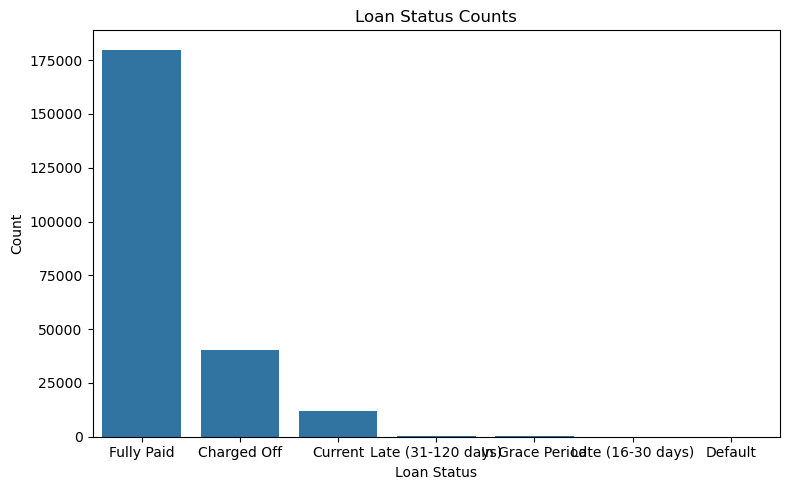

In [6]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='loan_status', order=df['loan_status'].value_counts().index)
plt.title('Loan Status Counts')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Train and Test Split

In [9]:
# Converting loan_status to a binary variable, and then split the data into traint and test
df['loan_status'] = df['loan_status'].isin(['Charged Off', 'Default']).astype(int)

# Split 80% train, 20% test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['loan_status'])

# 1. Probability of Default

In this part of the project, I focus on predicting whether a borrower will default on their loan or not. This is a binary classification problem, where the target variable is defined as: 


$$
\text{loan\_status} = 
\begin{cases}
1 & \text{if the loan is charged-off (default)} \\
0 & \text{if the loan is fully paid}
\end{cases}
$$


The goal is to estimate the Probability of Default (PD) for each loan, which is defined as:

$$
\text{PD} = P(\text{loan\_status} = 1 \mid \text{features})
$$


## 1.1 Removing some features

For the probability of default, there are some irrelevant features and we can remove them. Also, some features are revealed after observing the default outcome, called **post-outcome information** (i.e., payments, recoveries). Therefore, we do not use those features in predicting the default. 

**Identifiers / Irrelevant / Redundant Features**

&emsp; &emsp; ``id``

&emsp; &emsp; ``url``

&emsp; &emsp; ``title``           free text, not structured

&emsp; &emsp; ``zip_code``        high cardinality, privacy concern

&emsp; &emsp; ``loan_status``     target variable — should not be used as a feature

&emsp; &emsp; ``funded_amnt``      the same as loan_amnt 

&emsp; &emsp; ``funded_amnt_inv``   correlated with funded_amnt

&emsp; &emsp; ``issue_d``   year and month have been extracted

&emsp; &emsp; ``issue_year``   removed bc we just use data from 2014

&emsp; &emsp; ``earliest_cr_line``

**Post-Outcome Information (payment and recovery info)**

&emsp; &emsp; ``out_prncp``

&emsp; &emsp; ``out_prncp_inv``

&emsp; &emsp; ``total_pymnt``

&emsp; &emsp; ``total_pymnt_inv``

&emsp; &emsp; ``total_rec_prncp``

&emsp; &emsp; ``total_rec_int``

&emsp; &emsp; ``total_rec_late_fee``

&emsp; &emsp; ``recoveries``

&emsp; &emsp; ``collection_recovery_fee``

&emsp; &emsp; ``last_pymnt_d``

&emsp; &emsp; ``last_pymnt_amnt``

&emsp; &emsp; ``last_credit_pull_d``

&emsp; &emsp; ``last_fico_range_high``

&emsp; &emsp; ``last_fico_range_low``

&emsp; &emsp; ``chargeoff_within_12_mths``

&emsp; &emsp; ``delinq_amnt``

In [10]:
PD_features_to_remove = [
    "id", "url", "title", "zip_code", "funded_amnt","funded_amnt_inv",
    "out_prncp", "out_prncp_inv", 'earliest_cr_line', 'issue_d',
    "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int",
    "total_rec_late_fee", "recoveries", "collection_recovery_fee",
    "last_pymnt_d", "last_pymnt_amnt", "last_credit_pull_d",
    "last_fico_range_high", "last_fico_range_low",
    "chargeoff_within_12_mths", "delinq_amnt"
]



In [11]:
pd_train_df = train_df.drop(columns=PD_features_to_remove)
pd_test_df = test_df.drop(columns=PD_features_to_remove)
pd_train_df

,loan_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,loan_status,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,issue_month
140249,24000.0,36 months,7.69,748.65,A,A4,RENT,98124.0,Source Verified,0,...,0.0,89.5,14.3,0.0,0.0,50718.0,24722.0,36300.0,3825.0,6
41358,14000.0,60 months,18.99,363.10,E,E1,OWN,98515.0,Not Verified,0,...,3.0,96.0,100.0,0.0,0.0,120064.0,104282.0,10000.0,107764.0,10
150836,10000.0,36 months,11.67,330.57,B,B4,RENT,35000.0,Not Verified,0,...,3.0,97.6,8.3,0.0,0.0,43341.0,11916.0,25800.0,3941.0,5
67765,35000.0,60 months,12.49,787.25,B,B5,MORTGAGE,325000.0,Verified,0,...,0.0,86.5,75.0,0.0,0.0,762720.0,24006.0,16700.0,0.0,10
38799,6600.0,36 months,13.35,223.50,C,C2,RENT,40000.0,Source Verified,0,...,3.0,82.4,50.0,1.0,0.0,19993.0,15567.0,1800.0,15593.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212154,14400.0,60 months,16.24,352.02,C,C5,MORTGAGE,55000.0,Source Verified,0,...,1.0,100.0,50.0,0.0,0.0,193551.0,45489.0,44342.0,21694.0,2
161813,8000.0,36 months,11.99,265.68,B,B3,MORTGAGE,100000.0,Not Verified,0,...,2.0,96.4,100.0,0.0,0.0,305364.0,56777.0,7100.0,23384.0,5
82124,11700.0,36 months,12.49,391.36,B,B5,MORTGAGE,60000.0,Not Verified,0,...,2.0,100.0,75.0,1.0,0.0,221576.0,28760.0,11900.0,30476.0,8
109767,6400.0,36 months,10.99,209.50,B,B3,RENT,82000.0,Not Verified,0,...,3.0,79.0,33.3,1.0,0.0,52209.0,25870.0,11125.0,37284.0,7


## Removing numerical features which are highly correlated

When two numerical features are highly correlated, they basically carry the same information. Keeping both doesn't help the model — in fact, it can make things worse by creating multicollinearity, especially in linear models.

To deal with this, I calculate the correlation between all numerical features. If the absolute value of correlation between any two features is very high (for example, above 0.8), I drop one of them. I usually keep the one that seems more useful or less correlated with other variables.

This step helps clean up the data, avoid redundancy, and make the model more stable and easier to interpret.

In [11]:
corr_threshold = 0.8

corr_matrix  = pd_train_df.select_dtypes(include='number').corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find pairs of features with correlation > threshold 
high_corr_pairs = [
    (col1, col2, upper.loc[col1, col2])
    for col1 in upper.columns
    for col2 in upper.index
    if upper.loc[col1, col2] > corr_threshold
]
high_corr_pairs


[('loan_amnt', 'installment', 0.9475764806742158),
 ('fico_range_low', 'fico_range_high', 0.999999962298794),
 ('open_acc', 'num_op_rev_tl', 0.8112803875817093),
 ('open_acc', 'num_sats', 0.9986470314400393),
 ('revol_bal', 'total_rev_hi_lim', 0.8120031535395621),
 ('revol_util', 'bc_util', 0.8188498567695431),
 ('acc_now_delinq', 'num_tl_30dpd', 0.8138786553838449),
 ('tot_cur_bal', 'avg_cur_bal', 0.8470108246438159),
 ('tot_cur_bal', 'tot_hi_cred_lim', 0.975216681684822),
 ('avg_cur_bal', 'tot_hi_cred_lim', 0.809440314666239),
 ('bc_open_to_buy', 'total_bc_limit', 0.8315182948384476),
 ('bc_util', 'percent_bc_gt_75', 0.8288174386491094),
 ('num_actv_bc_tl', 'num_bc_sats', 0.8326489381615061),
 ('num_actv_rev_tl', 'num_op_rev_tl', 0.8062686141391344),
 ('num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 0.989444882258337),
 ('num_bc_tl', 'num_rev_accts', 0.8378067285923642),
 ('num_op_rev_tl', 'num_rev_tl_bal_gt_0', 0.8094644132672286),
 ('num_op_rev_tl', 'num_sats', 0.8109163288987492),
 ('to

Given the correlation between each pair of variables, I need to decide which variable should be removed. In the following, I listed the set of variables to be removed. 

In [12]:
pd_num_cor_features_to_drop  = [
    'installment',
    'fico_range_low',
    'open_acc',
    'total_rev_hi_lim',
    'bc_util',
    'avg_cur_bal',
    'tot_hi_cred_lim',
    'total_bc_limit',
    'percent_bc_gt_75',
    'num_actv_bc_tl',
    'num_bc_sats',
    'num_actv_rev_tl',
    'num_bc_tl',
    'num_op_rev_tl',
    'total_il_high_credit_limit'
]
print('The number of numerical features which should be removed because of high correlation: ', len(pd_num_cor_features_to_drop))

The number of numerical features which should be removed because of high correlation:  15


In [13]:
pd_train_df = pd_train_df.drop(columns=pd_num_cor_features_to_drop)
pd_test_df = pd_test_df.drop(columns=pd_num_cor_features_to_drop)
pd_train_df.shape

(186196, 44)

In [14]:
pd_train_df

,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,annual_inc,verification_status,loan_status,purpose,...,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,issue_month
140249,24000.0,36 months,7.69,A,A4,RENT,98124.0,Source Verified,0,debt_consolidation,...,6.0,10.0,0.0,0.0,0.0,89.5,0.0,0.0,24722.0,6
41358,14000.0,60 months,18.99,E,E1,OWN,98515.0,Not Verified,0,debt_consolidation,...,3.0,9.0,0.0,0.0,3.0,96.0,0.0,0.0,104282.0,10
150836,10000.0,36 months,11.67,B,B4,RENT,35000.0,Not Verified,0,debt_consolidation,...,16.0,25.0,0.0,0.0,3.0,97.6,0.0,0.0,11916.0,5
67765,35000.0,60 months,12.49,B,B5,MORTGAGE,325000.0,Verified,0,credit_card,...,9.0,12.0,0.0,0.0,0.0,86.5,0.0,0.0,24006.0,10
38799,6600.0,36 months,13.35,C,C2,RENT,40000.0,Source Verified,0,debt_consolidation,...,4.0,9.0,0.0,3.0,3.0,82.4,1.0,0.0,15567.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212154,14400.0,60 months,16.24,C,C5,MORTGAGE,55000.0,Source Verified,0,credit_card,...,14.0,22.0,0.0,0.0,1.0,100.0,0.0,0.0,45489.0,2
161813,8000.0,36 months,11.99,B,B3,MORTGAGE,100000.0,Not Verified,0,debt_consolidation,...,4.0,8.0,0.0,0.0,2.0,96.4,0.0,0.0,56777.0,5
82124,11700.0,36 months,12.49,B,B5,MORTGAGE,60000.0,Not Verified,0,credit_card,...,6.0,11.0,0.0,0.0,2.0,100.0,1.0,0.0,28760.0,8
109767,6400.0,36 months,10.99,B,B3,RENT,82000.0,Not Verified,0,credit_card,...,10.0,13.0,0.0,0.0,3.0,79.0,1.0,0.0,25870.0,7


# Feature Selection Using LightGBM and Oversampling with F1-Score Metric

In this section, I try to identify which features are most useful in predicting loan default using LightGBM. First, I prepare the dataset by separating features (``X``) and the target variable (``y``), which is ``loan_status``. Since LightGBM can directly handle categorical features, there is no need for one-hot encoding. Then, I set up 10-fold stratified cross-validation to make sure each fold maintains the same class distribution (i.e., similar proportion of defaults and non-defaults). Because the dataset is imbalanced — most loans are fully paid and only a small portion are charged off — I apply random oversampling to the training data in each fold. This helps the model learns from both classes equally. For each fold, I train a LightGBM classifier on the balanced data and evaluate its performance using the F1 score on the validation set. To measure feature importance, I use ``permutation importance`` on the validation data. I also weight the importance scores by the F1 score from each fold, so that folds with better predictive performance contribute more. 

In [16]:
# Prepare data
X = pd_train_df.drop(columns=['loan_status'])
y = pd_train_df['loan_status']

# Convert object columns to category dtype for LightGBM
categorical_feature = list(X.select_dtypes(include=["object", "category"]).columns)
for col in categorical_feature:
    X[col] = X[col].astype('category')

# Stratified K-Fold CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Store feature importances weighted by F1 score
feature_importances = pd.DataFrame(index=X.columns)

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print(f'LightGBM fold {fold+1}/10 is running ....')
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Oversample minority class in training set
    ros = RandomOverSampler(random_state=42)
    X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

    # Train model
    model = lgb.LGBMClassifier(random_state=42, verbose=-1)
    model.fit(X_train_res, y_train_res, categorical_feature=categorical_feature)

    # F1 score
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred)

    # Weight feature importances by F1 score
    perm_importance = permutation_importance(model, X_val, y_val, scoring='f1', random_state=42)
    feature_importances[f'fold_{fold+1}'] = perm_importance.importances_mean * f1

    

# Compute average importance
feature_importances['mean_importance'] = feature_importances.mean(axis=1)
feature_importances = feature_importances.sort_values(by='mean_importance', ascending=False)




LightGBM fold 1/10 is running ....
LightGBM fold 2/10 is running ....
LightGBM fold 3/10 is running ....
LightGBM fold 4/10 is running ....
LightGBM fold 5/10 is running ....
LightGBM fold 6/10 is running ....
LightGBM fold 7/10 is running ....
LightGBM fold 8/10 is running ....
LightGBM fold 9/10 is running ....
LightGBM fold 10/10 is running ....


In [22]:
feature_importances = feature_importances[feature_importances['mean_importance']>0]
feature_importance_df = (
    feature_importances[['mean_importance']]
    .sort_values(by='mean_importance', ascending=False)
    .assign(cum_importance=lambda df: df['mean_importance'].cumsum() / df['mean_importance'].sum())
    .reset_index()
    .rename(columns={'index': 'Feature', 'mean_importance': 'mean_importance'})
)

feature_importance_df


,Feature,mean_importance,cum_importance
0,sub_grade,1.362132e-02,0.422148
1,loan_amnt,2.716174e-03,0.506327
2,annual_inc,1.887480e-03,0.564823
3,term,1.802986e-03,0.620700
4,acc_open_past_24mths,1.759161e-03,0.675220
5,addr_state,1.548085e-03,0.723198
6,grade,1.118346e-03,0.757857
7,dti,9.983564e-04,0.788798
8,revol_bal,7.953846e-04,0.813448
9,mo_sin_old_rev_tl_op,7.418796e-04,0.836440


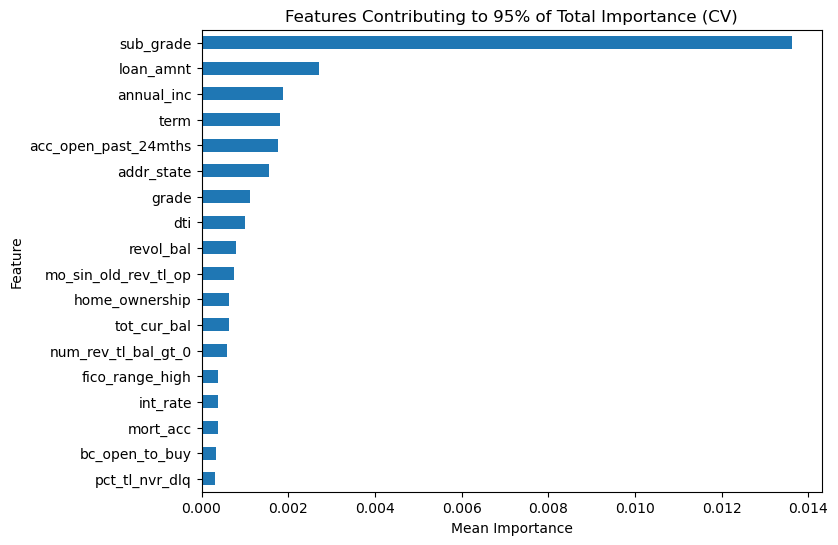

In [26]:
threshold = 0.95

# Filter features until cumulative importance reaches the threshold
threshold_df = feature_importance_df[feature_importance_df['cum_importance'] <= threshold]


# Plot
threshold_df.plot(kind='barh', x='Feature', y='mean_importance', figsize=(8, 6), legend=False)
plt.gca().invert_yaxis()
plt.title(f"Features Contributing to {threshold*100:.0f}% of Total Importance (CV)")
plt.xlabel("Mean Importance")
plt.show()


### The list of features that are the most important and are kept for further analysis

In [27]:
threshold_df

,Feature,mean_importance,cum_importance
0,sub_grade,0.013621,0.422148
1,loan_amnt,0.002716,0.506327
2,annual_inc,0.001887,0.564823
3,term,0.001803,0.620700
4,acc_open_past_24mths,0.001759,0.675220
5,addr_state,0.001548,0.723198
6,grade,0.001118,0.757857
7,dti,0.000998,0.788798
8,revol_bal,0.000795,0.813448
9,mo_sin_old_rev_tl_op,0.000742,0.836440


In [28]:
pd_target = 'loan_status'   # Use binary target for default prediction
pd_feature = threshold_df['Feature'].tolist()
print('The number of features: ', len(pd_feature))
pd_feature

The number of features:  18


['sub_grade',
 'loan_amnt',
 'annual_inc',
 'term',
 'acc_open_past_24mths',
 'addr_state',
 'grade',
 'dti',
 'revol_bal',
 'mo_sin_old_rev_tl_op',
 'home_ownership',
 'tot_cur_bal',
 'num_rev_tl_bal_gt_0',
 'fico_range_high',
 'int_rate',
 'mort_acc',
 'bc_open_to_buy',
 'pct_tl_nvr_dlq']

In [7]:
pd_feature = ['sub_grade',
 'loan_amnt',
 'annual_inc',
 'term',
 'acc_open_past_24mths',
 'addr_state',
 'grade',
 'dti',
 'revol_bal',
 'mo_sin_old_rev_tl_op',
 'home_ownership',
 'tot_cur_bal',
 'num_rev_tl_bal_gt_0',
 'fico_range_high',
 'int_rate',
 'mort_acc',
 'bc_open_to_buy',
 'pct_tl_nvr_dlq']

### Training data after feature selection

In [12]:
pd_train_df = pd_train_df[pd_feature+['loan_status']]
pd_train_df

,sub_grade,loan_amnt,annual_inc,term,acc_open_past_24mths,addr_state,grade,dti,revol_bal,mo_sin_old_rev_tl_op,home_ownership,tot_cur_bal,num_rev_tl_bal_gt_0,fico_range_high,int_rate,mort_acc,bc_open_to_buy,pct_tl_nvr_dlq,loan_status
140249,A4,24000.0,98124.0,36 months,1.0,TX,A,11.02,21199.0,350.0,RENT,24722.0,6.0,694.0,7.69,0.0,16093.0,89.5,0
41358,E1,14000.0,98515.0,60 months,3.0,MD,E,24.05,10487.0,198.0,OWN,104282.0,3.0,714.0,18.99,0.0,0.0,96.0,0
150836,B4,10000.0,35000.0,36 months,12.0,FL,B,16.98,9195.0,121.0,RENT,11916.0,16.0,694.0,11.67,0.0,19169.0,97.6,0
67765,B5,35000.0,325000.0,60 months,0.0,MI,B,4.94,24006.0,249.0,MORTGAGE,750692.0,9.0,669.0,12.49,5.0,1401.0,86.5,0
38799,C2,6600.0,40000.0,36 months,8.0,OR,C,13.48,1214.0,365.0,RENT,15567.0,4.0,664.0,13.35,7.0,706.0,82.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212154,C5,14400.0,55000.0,60 months,8.0,TN,C,29.29,30925.0,149.0,MORTGAGE,141838.0,14.0,699.0,16.24,4.0,20610.0,100.0,0
161813,B3,8000.0,100000.0,36 months,4.0,MD,B,14.76,34120.0,328.0,MORTGAGE,285139.0,4.0,679.0,11.99,5.0,690.0,96.4,0
82124,B5,11700.0,60000.0,36 months,4.0,IL,B,18.38,13591.0,170.0,MORTGAGE,195200.0,6.0,674.0,12.49,3.0,3030.0,100.0,0
109767,B3,6400.0,82000.0,36 months,4.0,CA,B,13.08,6335.0,268.0,RENT,25870.0,10.0,684.0,10.99,10.0,1236.0,79.0,0


###  Visualization of selected features

Based on the following figure, we can observe that some of the numerical features are highly skewed. For some approaches XGBoost, this is not an issue. However, for some approaches like logistic regression, it is better to transform the data using ***log*** function.

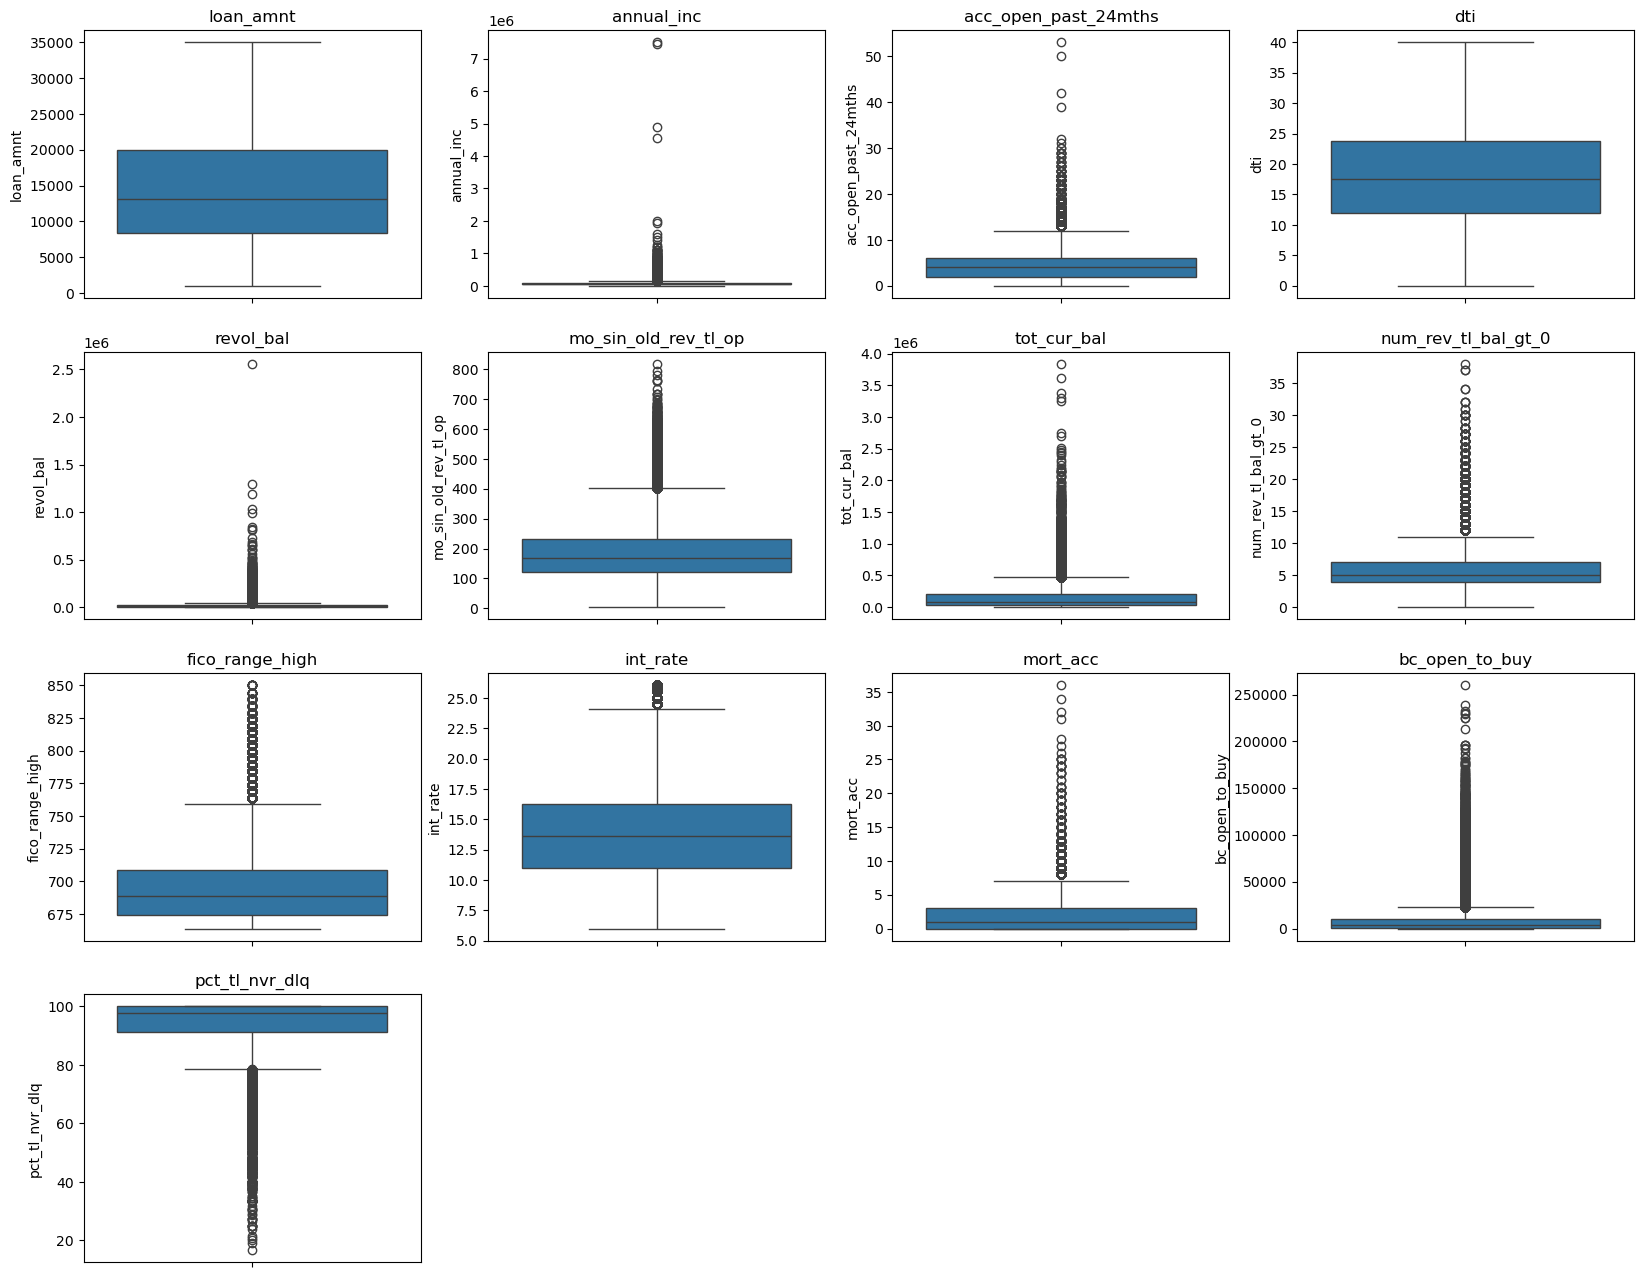

In [46]:
# Select numerical columns
num_cols = pd_train_df[pd_feature].select_dtypes(include='number').columns

# Number of rows and columns for the subplot
n_cols = 4  
n_rows = math.ceil(len(num_cols) / n_cols)

# Create figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # Flatten in case of single row

# Plot boxplot for each numerical feature
for i, col in enumerate(num_cols):
    sns.boxplot(data=pd_train_df[pd_feature], y=col, ax=axes[i])
    axes[i].set_title(col)
    
# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


### Distribution of numerical features when they are transformed  by log function

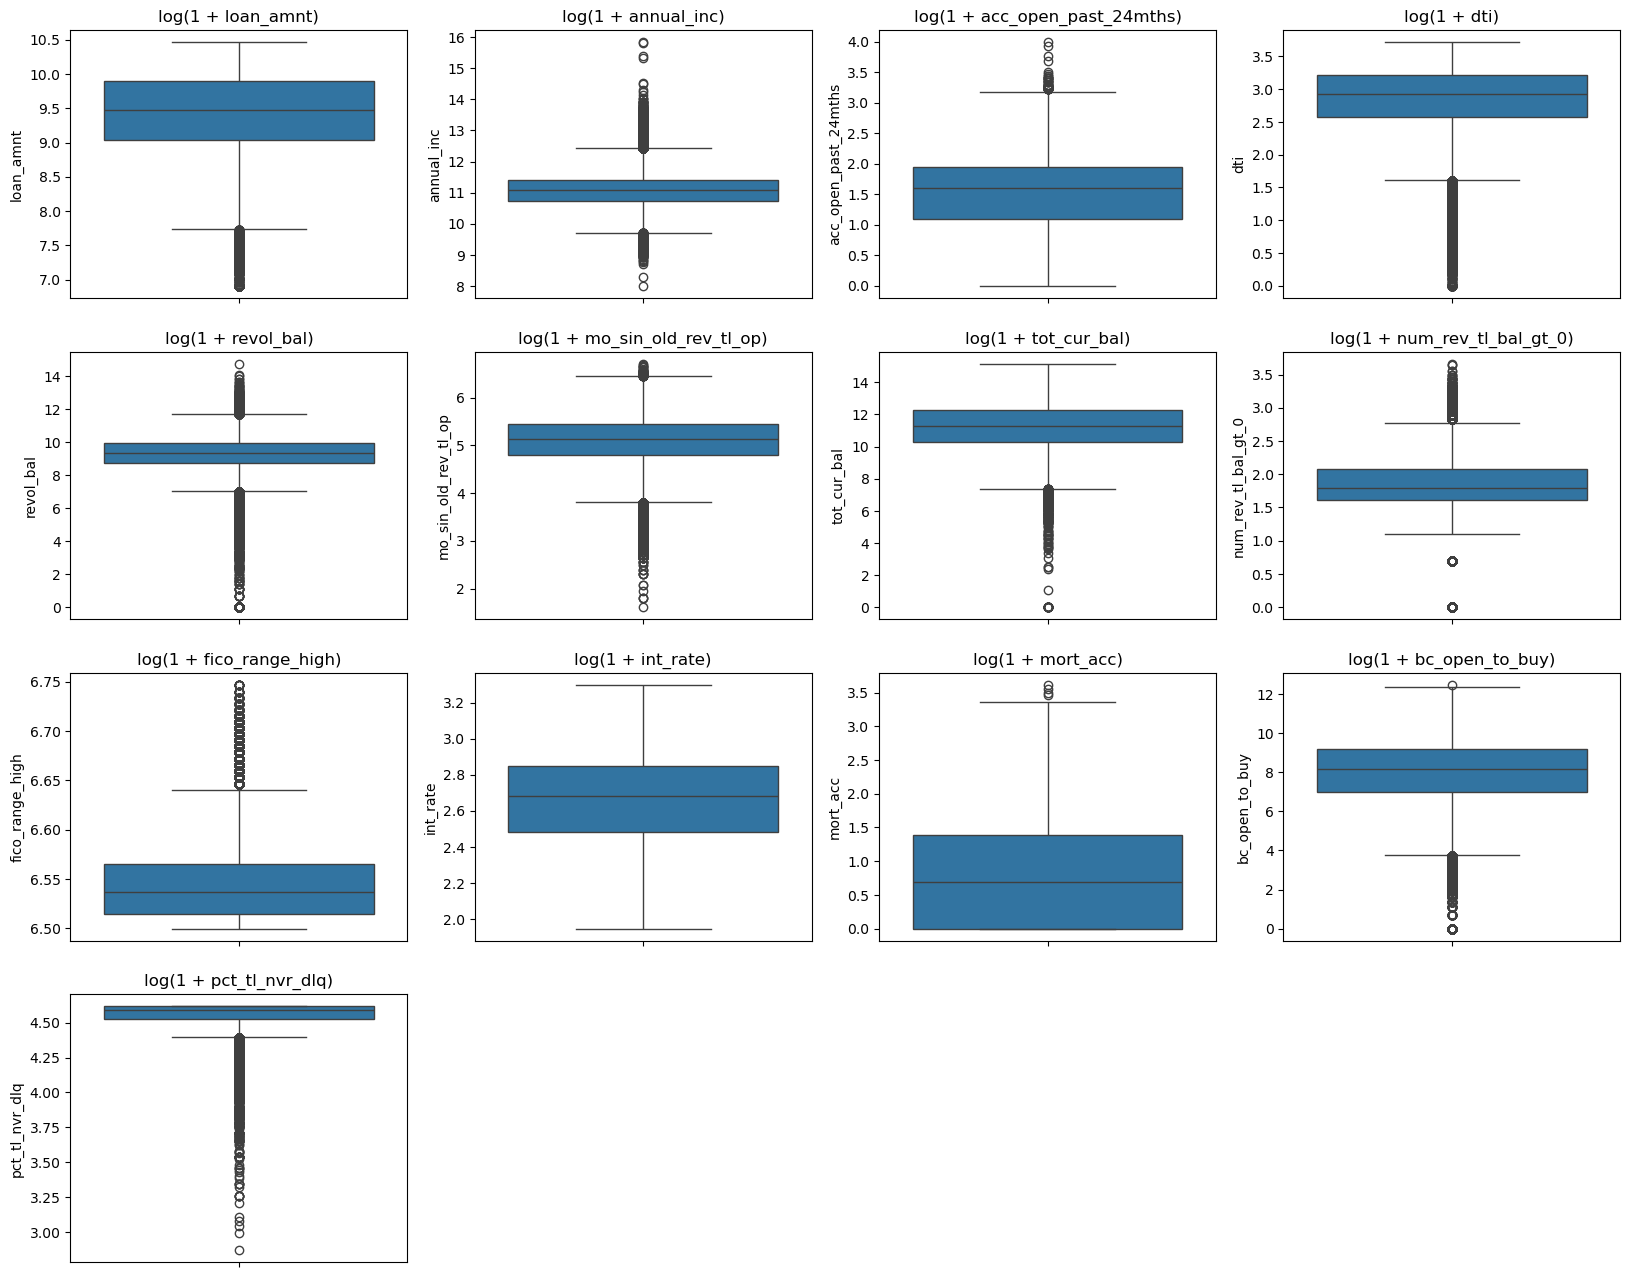

In [47]:
# Create figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Plot log-transformed boxplots
for i, col in enumerate(num_cols):
    log_data = np.log1p(pd_train_df[pd_feature][col])
    sns.boxplot(y=log_data, ax=axes[i])
    axes[i].set_title(f"log(1 + {col})")
    
# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


### Distribution of categorical features

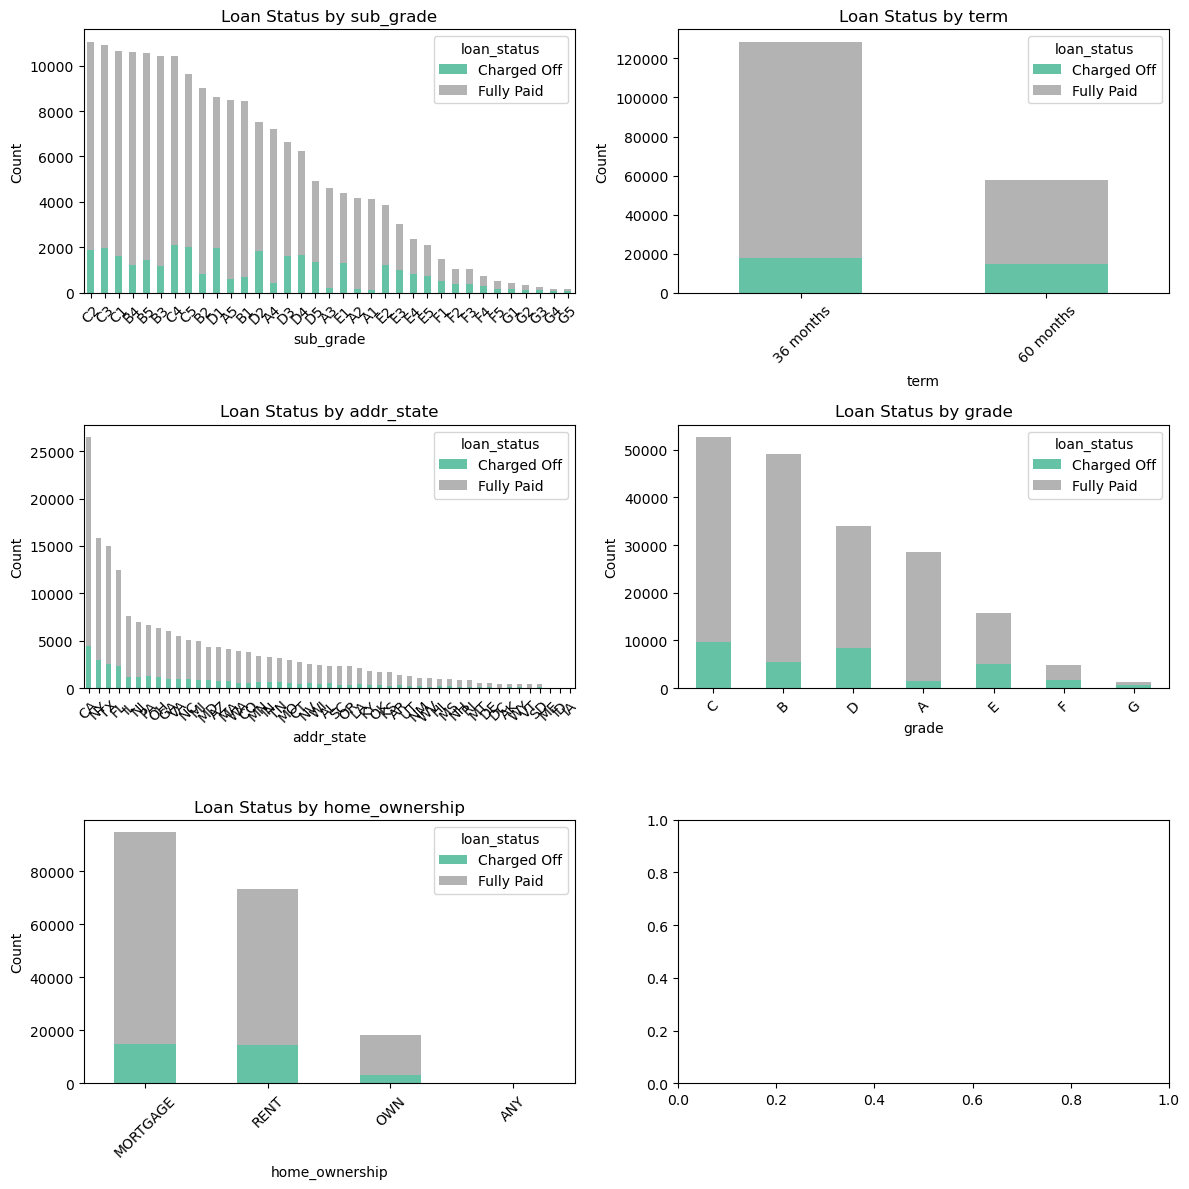

In [53]:
# Select categorical features
cat_cols = pd_train_df.select_dtypes(include=['object', 'category']).columns

# Number of plots per row
n_cols = 2
n_rows = -(-len(cat_cols) // n_cols)  # Ceiling division

# Set up the subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Map loan_status to readable labels
df_plot = pd_train_df.copy()
df_plot['loan_status'] = df_plot['loan_status'].map({0: 'Fully Paid', 1: 'Charged Off'})

# Plot stacked bar chart for each categorical feature
for i, col in enumerate(cat_cols):
    # Compute counts and sort by total frequency
    counts = df_plot.groupby([col, 'loan_status']).size().unstack(fill_value=0)
    counts = counts.loc[counts.sum(axis=1).sort_values(ascending=False).index]  # Sort rows by total

    counts.plot(kind='bar', stacked=True, ax=axes[i], colormap='Set2')
    axes[i].set_title(f"Loan Status by {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)


### Visualization of the distribtuion of data

n this UMAP plot, each point represents a loan, and we colored them based on ``loan_status``—green for non-default (0) and red for default (1). What we see is that the two classes are pretty mixed, with no clear boundary separating defaults from non-defaults. While there are some areas where red points are a bit more concentrated (especially on the right), overall, the red and green dots are scattered across the space. This suggests that the classification problem is not simple, and the decision boundary between the two classes is likely complex. It also means we’ll need a non-linear model (like LightGBM or XGBoost) to capture the underlying patterns. So, UMAP helps us confirm that predicting loan defaults won't be trivial and probably requires richer features or more advanced modeling.

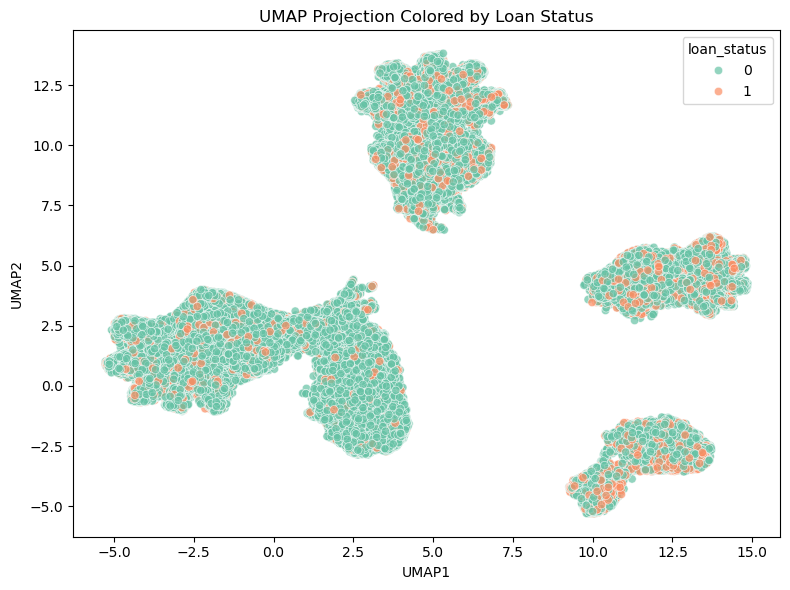

In [54]:
def umap_visualization(dataframe):

    # 1. Copy data
    data = dataframe[pd_feature].copy()
    
    # 2. Separate numerical and categorical
    num_cols = list(data.select_dtypes(include='number').columns)
    num_cols = [col for col in num_cols if col != 'loan_status']
    cat_cols = data.select_dtypes(include=['object', 'category']).columns
    
    # 3. One-hot encode categorical features
    X_encoded = pd.concat([
        data[num_cols],
        pd.get_dummies(data[cat_cols], drop_first=True)
    ], axis=1)
    
    # 4. Scale numeric features only
    X_encoded[num_cols] = StandardScaler().fit_transform(X_encoded[num_cols])
    
    # 5. Apply UMAP
    umap = UMAP(n_components=2, random_state=42)
    X_umap = umap.fit_transform(X_encoded)
    
    # 6. Build a DataFrame for plotting
    umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
    umap_df["loan_status"] = dataframe["loan_status"].values
    
    # 7. Visualize with seaborn
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="loan_status", alpha=0.7, palette="Set2")
    plt.title("UMAP Projection Colored by Loan Status")
    plt.tight_layout()
    plt.show()

umap_visualization(pd_train_df[pd_feature+['loan_status']])

## Using PCA for visualization

For visualization, we start with standard PCA since Kernel PCA requires a lot of memory, which my laptop can’t handle. First, we apply PCA on the original data, and then again after transforming the numerical features using the **log** of their values. In both cases, the two classes are not clearly separable, which confirms that the classification task is challenging.

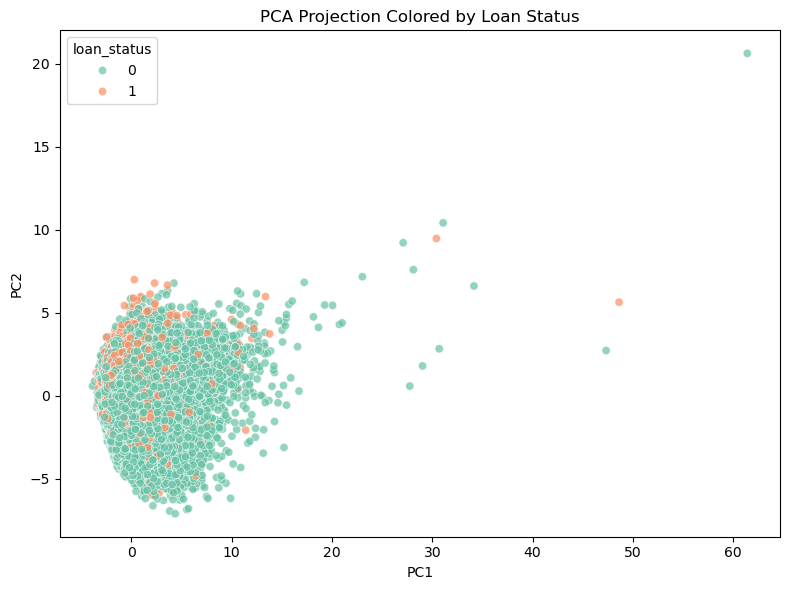

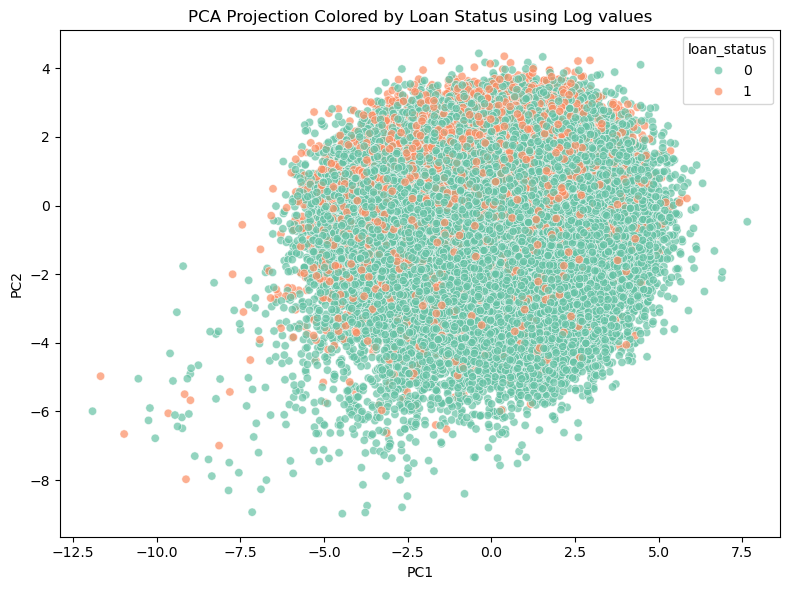

In [55]:
def pca_visualization(dataframe, method='normal'):
    # Step 1: Prepare data
    data = dataframe[pd_feature].copy()
    
    num_cols = list(data.select_dtypes(include='number').columns)
    num_cols = [col for col in num_cols if col != 'loan_status']
    cat_cols = data.select_dtypes(include=['object', 'category']).columns
    
    # One-hot encode categoricals
    X_encoded = pd.concat([
        data[num_cols],
        pd.get_dummies(data[cat_cols], drop_first=True)
    ], axis=1)
    
    # Scale numeric features
    if method !='normal':
        X_encoded[num_cols] = np.log(1+X_encoded[num_cols])
    X_encoded[num_cols] = StandardScaler().fit_transform(X_encoded[num_cols])
    
    # Step 2: Apply PCA (you can switch to KernelPCA later)
    # pca = PCA(n_components=2)
    pca = PCA(n_components=2)  # or try 'poly', 'sigmoid', etc.
    X_pca = pca.fit_transform(X_encoded)
    
    # Step 3: Create a DataFrame for visualization
    pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
    pca_df["loan_status"] = dataframe["loan_status"].values
    
    # Step 4: Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="loan_status", alpha=0.7, palette="Set2")
    if method=='normal':
        plt.title("PCA Projection Colored by Loan Status")
    else:
        plt.title("PCA Projection Colored by Loan Status using Log values")
    plt.tight_layout()
    plt.show()

pca_visualization(pd_train_df[pd_feature+['loan_status']], method='normal')
pca_visualization(pd_train_df[pd_feature+['loan_status']], method='log')

In [56]:
pd_train_df

,sub_grade,loan_amnt,annual_inc,term,acc_open_past_24mths,addr_state,grade,dti,revol_bal,mo_sin_old_rev_tl_op,home_ownership,tot_cur_bal,num_rev_tl_bal_gt_0,fico_range_high,int_rate,mort_acc,bc_open_to_buy,pct_tl_nvr_dlq,loan_status
140249,A4,24000.0,98124.0,36 months,1.0,TX,A,11.02,21199.0,350.0,RENT,24722.0,6.0,694.0,7.69,0.0,16093.0,89.5,0
41358,E1,14000.0,98515.0,60 months,3.0,MD,E,24.05,10487.0,198.0,OWN,104282.0,3.0,714.0,18.99,0.0,0.0,96.0,0
150836,B4,10000.0,35000.0,36 months,12.0,FL,B,16.98,9195.0,121.0,RENT,11916.0,16.0,694.0,11.67,0.0,19169.0,97.6,0
67765,B5,35000.0,325000.0,60 months,0.0,MI,B,4.94,24006.0,249.0,MORTGAGE,750692.0,9.0,669.0,12.49,5.0,1401.0,86.5,0
38799,C2,6600.0,40000.0,36 months,8.0,OR,C,13.48,1214.0,365.0,RENT,15567.0,4.0,664.0,13.35,7.0,706.0,82.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212154,C5,14400.0,55000.0,60 months,8.0,TN,C,29.29,30925.0,149.0,MORTGAGE,141838.0,14.0,699.0,16.24,4.0,20610.0,100.0,0
161813,B3,8000.0,100000.0,36 months,4.0,MD,B,14.76,34120.0,328.0,MORTGAGE,285139.0,4.0,679.0,11.99,5.0,690.0,96.4,0
82124,B5,11700.0,60000.0,36 months,4.0,IL,B,18.38,13591.0,170.0,MORTGAGE,195200.0,6.0,674.0,12.49,3.0,3030.0,100.0,0
109767,B3,6400.0,82000.0,36 months,4.0,CA,B,13.08,6335.0,268.0,RENT,25870.0,10.0,684.0,10.99,10.0,1236.0,79.0,0


## Correlation Matrix Visualization

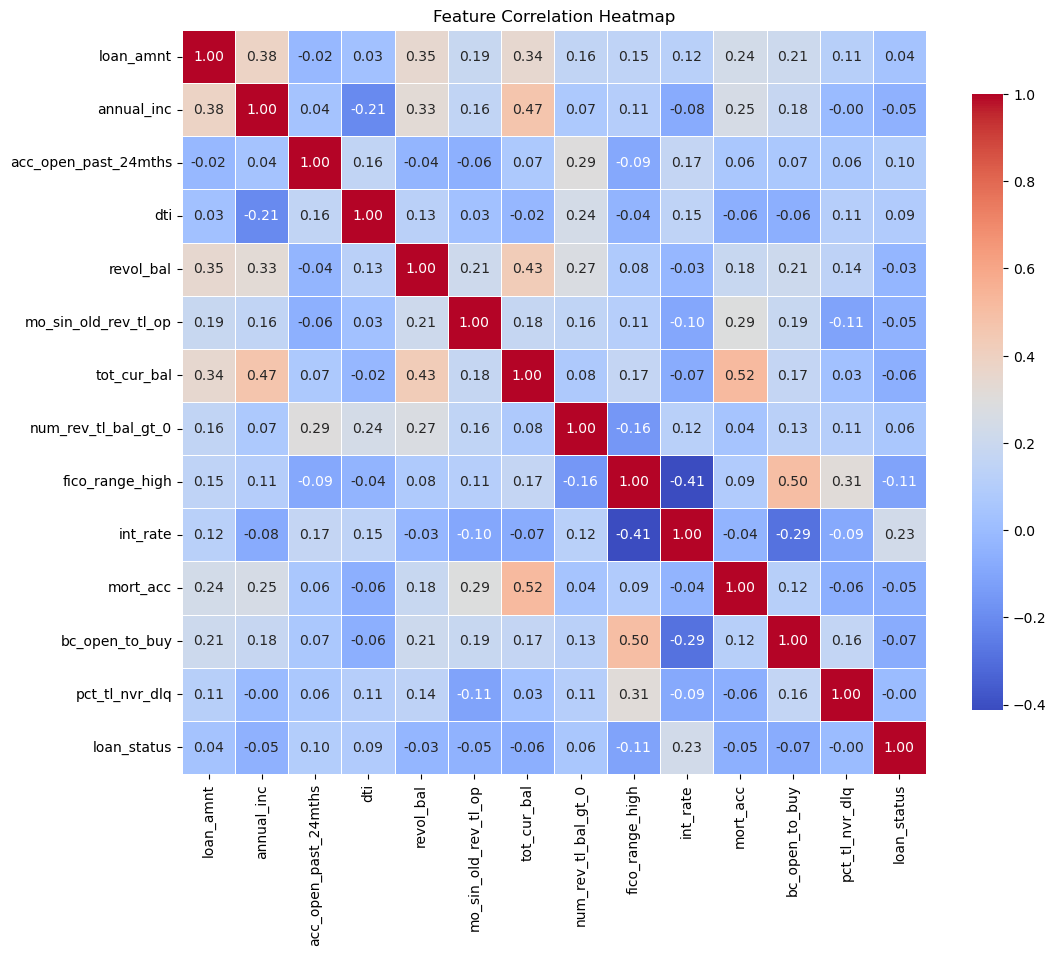

In [60]:
num_cols = list(pd_train_df.select_dtypes(include='number').columns)
df = pd_train_df[num_cols].copy()
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, linewidths=.5)
plt.title('Feature Correlation Heatmap')
plt.show()

In [ ]:
sns.pairplot(pd_train_df[num_cols], hue="loan_status")

# Classification

In [14]:
target = 'loan_status'

## Using Under/Over Sampling

In [15]:
def func_target_encoding(X, y):
    data = X.copy()
    num_cols = list(data.select_dtypes(include='number').columns)
    cat_cols = data.select_dtypes(include=['object', 'category']).columns

    # Start with numerical features
    X_encoded = data[num_cols].copy()

    # Target encode categoricals using y
    for col in cat_cols:
        means = y.groupby(data[col]).mean()
        X_encoded[col] = data[col].map(means).astype(float)  # <-- Force float dtype

    return X_encoded

In [16]:

# One-time preprocessing
X_raw = pd_train_df.drop(columns=['loan_status'])
y = pd_train_df['loan_status']

num_cols = X_raw.select_dtypes(include='number').columns
X_raw[num_cols] = np.log1p(X_raw[num_cols])

# Convert object columns to category (for LightGBM)
for col in X_raw.select_dtypes(include='object').columns:
    X_raw[col] = X_raw[col].astype('category')

# Scoring metrics
scoring = {
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
    'f1': make_scorer(f1_score),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'average_precision': make_scorer(average_precision_score, needs_proba=True)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model setup
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42, verbose=0),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, verbose=0),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, verbose=0)
}

# Evaluation loop
results = {}
for name, model in models.items():
    print(f"Running {name}...")

    if name in ['LightGBM']:
        X_model = X_raw.copy()
    else:
        # Use target encoding for categorical variables
        X_model = func_target_encoding(X_raw, y)

    if name =='XGBoost':
        # Oversampling
        ros = RandomOverSampler(random_state=42)
        X_res, y_res = ros.fit_resample(X_model, y)
        
        model.fit(X_res, y_res)
        y_pred = model.predict(X_res)
        y_prob = model.predict_proba(X_res)[:, 1]
        
        results[name] = {
            'roc_auc': roc_auc_score(y_res, y_prob),
            'f1': f1_score(y_res, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_res, y_pred),
            'average_precision': average_precision_score(y_res, y_prob)
        }

    else:
        # Use a pipeline with oversampling
        pipeline = Pipeline([
            ('sampler', RandomOverSampler(random_state=42)),
            ('model', model)
        ])

    # Evaluate
    scores = cross_validate(pipeline, X_model, y, cv=cv, scoring=scoring)
    results[name] = {metric: scores[f'test_{metric}'].mean() for metric in scoring}

# Show results
print('___'*10)
results_df = pd.DataFrame(results).T
print(results_df)


Running Random Forest...
Running Gradient Boosting...
Running LightGBM...
Running XGBoost...
Running Logistic Regression...
______________________________
                      roc_auc        f1  balanced_accuracy  average_precision
Random Forest        0.682280  0.141295           0.529760           0.296706
Gradient Boosting    0.701445  0.386434           0.645951           0.322557
LightGBM             0.697241  0.386113           0.643800           0.316380
XGBoost              0.700522  0.387132           0.645599           0.320577
Logistic Regression  0.700443  0.386731           0.645788           0.321828


## Logistic Regression

In [40]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

# Prepare data
df = pd_train_df.copy()
X = pd_train_df.drop(columns=['loan_status'])
y = pd_train_df['loan_status']


# Merge rare states into "Other"
df = df.drop(columns=['grade'])
state_counts = df['addr_state'].value_counts()
rare_states = state_counts[state_counts < 100].index
df['addr_state'] = df['addr_state'].apply(lambda x: 'Other' if x in rare_states else x)

subgrade_counts = df['sub_grade'].value_counts()
rare_subgrades = subgrade_counts[subgrade_counts < 100].index

df['sub_grade'] = df['sub_grade'].apply(lambda x: 'Other' if x in rare_subgrades else x)



target = 'loan_status'
num_cols = df.select_dtypes(include='number').columns.drop('loan_status')
cat_cols = df.select_dtypes(include='object').columns

# Optionally standardize numerical features to help convergence
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Generate formula parts
num_part = " + ".join(num_cols)
cat_part = " + ".join([f'C({col})' for col in cat_cols])

formula = f"{target} ~ {num_part} + {cat_part}"

# Add intercept term
X = sm.add_constant(X)

# Fit logistic regression using formula
model = smf.logit(formula, data=df)
result = model.fit()

# Summary
print(result.summary())


         Current function value: 0.425663
         Iterations: 35


C:\Users\shahmara\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:               186196
Model:                          Logit   Df Residuals:                   186098
Method:                           MLE   Df Model:                           97
Date:                Wed, 07 May 2025   Pseudo R-squ.:                 0.07914
Time:                        15:59:54   Log-Likelihood:                -79257.
converged:                      False   LL-Null:                       -86069.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -8.2700     31.806     -0.260      0.795     -70.609      54.069
C(sub_grade)[T.A2]                0.3957      0.125      3.175      0.001 

In [65]:
# Prepare data
df = pd_train_df.copy()
df = df.drop(columns=['grade'])  # Drop redundant feature
df = df[df['home_ownership'] != 'ANY']

# Merge rare states and subgrades into "Other"
state_counts = df['addr_state'].value_counts()
rare_states = state_counts[state_counts < 300].index
df['addr_state'] = df['addr_state'].apply(lambda x: 'Other' if x in rare_states else x)

subgrade_counts = df['sub_grade'].value_counts()
rare_subgrades = subgrade_counts[subgrade_counts < 300].index
df['sub_grade'] = df['sub_grade'].apply(lambda x: 'Other' if x in rare_subgrades else x)

# Identify numeric and categorical columns
target = 'loan_status'
num_cols = df.select_dtypes(include='number').columns.drop(target)
cat_cols = df.select_dtypes(include='object').columns

# Standardize numerical features
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Oversample before fitting
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(df.drop(columns=[target]), df[target])

# Combine oversampled data into new DataFrame
df_resampled = X_res.copy()
df_resampled[target] = y_res

# Build formula using categorical variables properly
num_part = " + ".join(num_cols)
cat_part = " + ".join([f'C({col})' for col in cat_cols])
formula = f"{target} ~ {num_part} + {cat_part}"

# Fit logistic regression
model = smf.logit(formula, data=df_resampled)
result = model.fit(maxiter=100)

# Show summary
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.629245
         Iterations 47
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:               307576
Model:                          Logit   Df Residuals:                   307481
Method:                           MLE   Df Model:                           94
Date:                Wed, 07 May 2025   Pseudo R-squ.:                 0.09219
Time:                        16:34:20   Log-Likelihood:            -1.9354e+05
converged:                       True   LL-Null:                   -2.1320e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -1.9327      0.109    -17.775      0.000      -2

In [83]:
# Get predicted probabilities (for class 1)
y_proba = result.predict(df)

# Class labels using default threshold of 0.5
y_pred = (y_proba >= 0.5).astype(int)

# True labels
y_true = df['loan_status']


In [84]:
len(y_proba)

186195

## ROC Curve and AUC Score

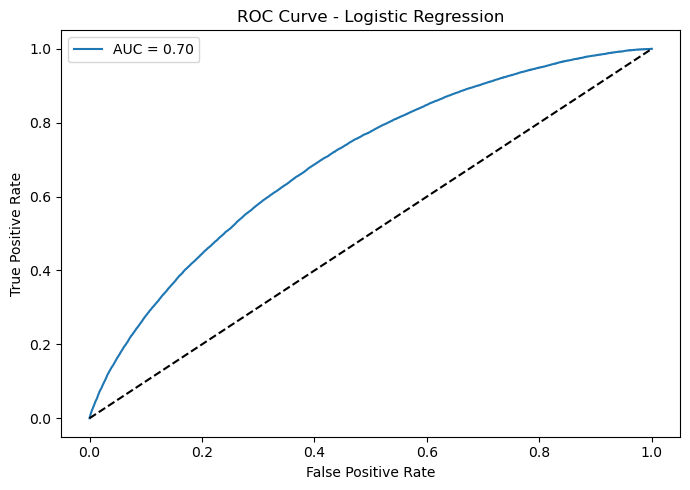

In [85]:
from sklearn.metrics import roc_curve, roc_auc_score


fpr, tpr, _ = roc_curve(y_true, y_proba)
auc = roc_auc_score(y_true, y_proba)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.tight_layout()
plt.show()


## Confusion Matrix and Classification Report

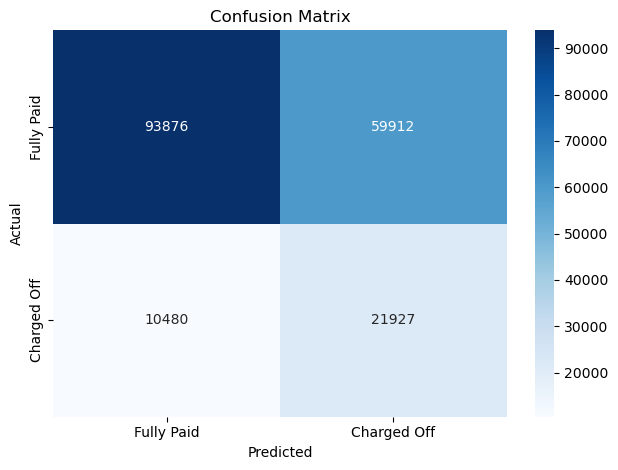

              precision    recall  f1-score   support

  Fully Paid       0.90      0.61      0.73    153788
 Charged Off       0.27      0.68      0.38     32407

    accuracy                           0.62    186195
   macro avg       0.58      0.64      0.56    186195
weighted avg       0.79      0.62      0.67    186195



In [86]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fully Paid', 'Charged Off'],
            yticklabels=['Fully Paid', 'Charged Off'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Text metrics
print(classification_report(y_true, y_pred, target_names=['Fully Paid', 'Charged Off']))


## Precision-Recall Curve and Average Precision Score

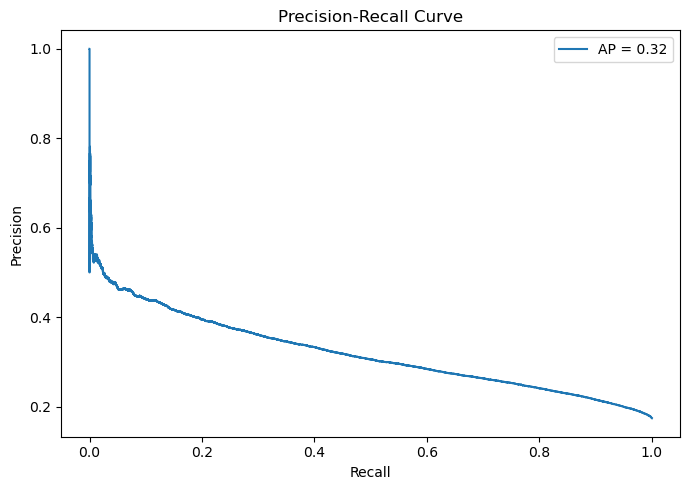

In [87]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_true, y_proba)
ap = average_precision_score(y_true, y_proba)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f'AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.tight_layout()
plt.show()


## The impact of the threshold probability on Precision, Recall, F1-Score

In the following figure, we change the threshold probability and determine its impact on three different metrics. Since the data is imbalanced, we pick a threshold that maximizes F1-Score.

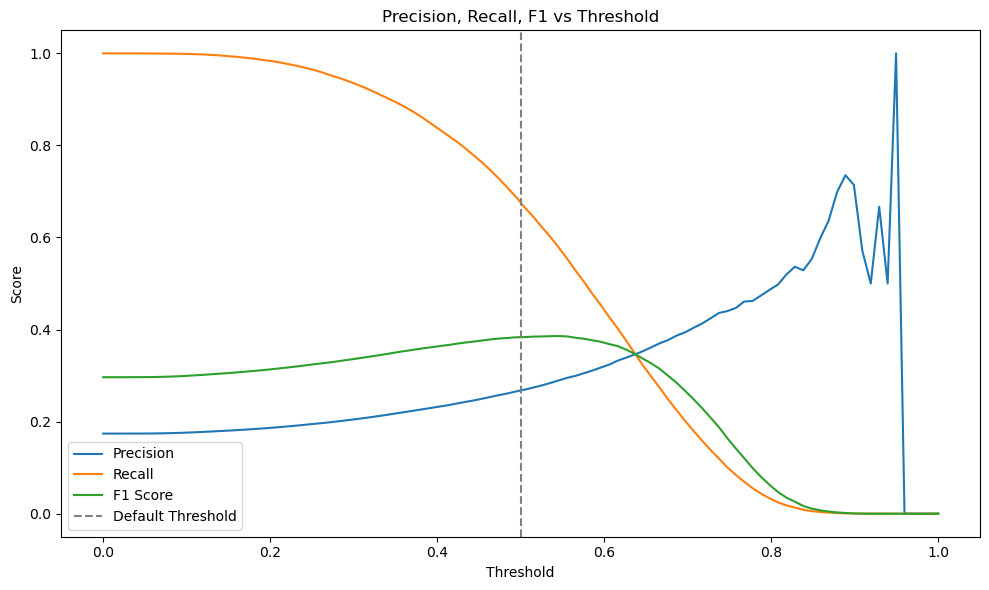

In [88]:
from sklearn.metrics import precision_recall_fscore_support

thresholds = np.linspace(0.0, 1.0, 100)
precisions, recalls, f1s = [], [], []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(df['loan_status'], y_pred_thresh, average='binary')
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.axvline(0.5, color='gray', linestyle='--', label='Default Threshold')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, F1 vs Threshold")
plt.legend()
plt.tight_layout()
plt.show()


### The choice of the threshold on the probability

Based on the above figure, I propsoe to choose the threshold 0.55 instead of the default value 0.5. 

Given this new threshold, the new confusion matrix would be as follows:


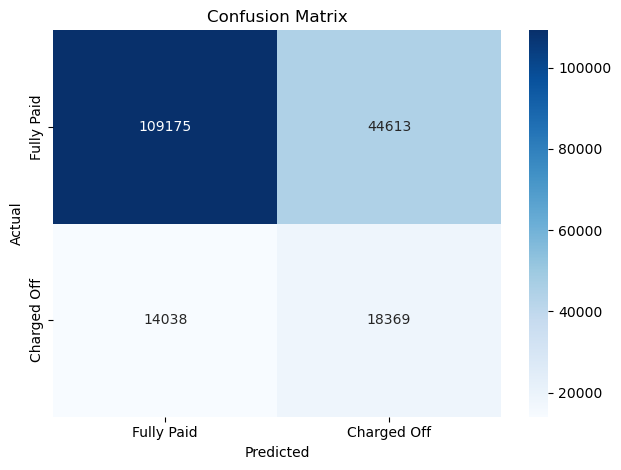

              precision    recall  f1-score   support

  Fully Paid       0.89      0.71      0.79    153788
 Charged Off       0.29      0.57      0.39     32407

    accuracy                           0.69    186195
   macro avg       0.59      0.64      0.59    186195
weighted avg       0.78      0.69      0.72    186195



In [90]:
threshold = 0.55
y_pred = (y_proba >= threshold).astype(int)

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fully Paid', 'Charged Off'],
            yticklabels=['Fully Paid', 'Charged Off'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Text metrics
print(classification_report(y_true, y_pred, target_names=['Fully Paid', 'Charged Off']))

# 2. Loss Prediction for Defaulted Loans

In this part of the analysis, we focus on predicting the monetary loss incurred from defaulted loans. Given that only loans with ``loan_status = 1`` are included, our target variable is continuous and strictly positive, making it suitable for ``Gamma regression``. We preprocess the data by applying log transformations to skewed numerical variables, and standardizing continuous predictors to improve convergence. This predictive modeling task helps estimate how much loss is expected from a defaulted loan, which is critical for risk management and provisioning in lending institutions.

In [91]:
# Filter defaulted loans
defaulted_train = train_df[train_df['loan_status'] == 1].copy()

# Calculate loss using eval
defaulted_train.eval(
    "loss = (funded_amnt - (total_rec_prncp +  recoveries ))",
    inplace=True
)

# Clip loss to ensure it's greater than 0
defaulted_train['loss'] = defaulted_train['loss'].clip(lower=0, upper=np.infty)


In [92]:
# Convert to datetime
defaulted_train['earliest_cr_line'] = pd.to_datetime(defaulted_train['earliest_cr_line'], format='%b-%Y')
# Extract year and month
defaulted_train['earliest_cr_line_year'] = defaulted_train['earliest_cr_line'].dt.year
defaulted_train['earliest_cr_line_month'] = defaulted_train['earliest_cr_line'].dt.month

# Drop the original column
defaulted_train.drop(columns='earliest_cr_line', inplace=True)

## Removing Irrelevant and Post-Outcome Features for Loss Prediction

To predict loss for defaulted loans accurately, we should only use features that were available before the default happened. Some features like ``id``, ``url``, or ``zip_code`` are irrelevant for prediction, so we remove them. Also, we drop features that contain information known after the loan outcome, such as how much was paid back or recovered (``total_pymnt``, ``recoveries``, etc.). Including these would cause data leakage, meaning the model learns from future information it wouldn’t have at prediction time. The list below shows which columns are removed for this reason:

In [95]:
irrelevant_features = [
    'id', 'url', 'title', 'zip_code', 'addr_state', 'issue_d', 'issue_month'
]

In [96]:
post_outcome_features = [
    'loan_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
    'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
    'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 
    'last_fico_range_high', 'last_fico_range_low'
]

lgd_removed_features = irrelevant_features + post_outcome_features

## Removing numerical features which are highly correlated

If the correlation between two numerical features is so high, one of them will be removed.

In [97]:
corr_threshold = 0.8

corr_matrix  = defaulted_train.select_dtypes(include='number').corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find pairs of features with correlation > threshold 
high_corr_pairs = [
    (col1, col2, upper.loc[col1, col2])
    for col1 in upper.columns
    for col2 in upper.index
    if upper.loc[col1, col2] > corr_threshold
]
high_corr_pairs


[('id', 'issue_month', 0.9545797173486604),
 ('loan_amnt', 'funded_amnt', 1.0),
 ('loan_amnt', 'funded_amnt_inv', 0.9999965766804455),
 ('loan_amnt', 'installment', 0.9407555070398417),
 ('loan_amnt', 'loss', 0.803906216156469),
 ('funded_amnt', 'funded_amnt_inv', 0.9999965766804455),
 ('funded_amnt', 'installment', 0.9407555070398417),
 ('funded_amnt', 'loss', 0.803906216156469),
 ('funded_amnt_inv', 'installment', 0.940757569687722),
 ('funded_amnt_inv', 'loss', 0.803924845858152),
 ('fico_range_low', 'fico_range_high', 0.9999999455720681),
 ('open_acc', 'num_op_rev_tl', 0.8026360435083176),
 ('open_acc', 'num_sats', 0.9988365024002743),
 ('revol_bal', 'total_rev_hi_lim', 0.8507789911973205),
 ('out_prncp', 'out_prncp_inv', 1.0),
 ('total_pymnt', 'total_pymnt_inv', 0.9999977396831337),
 ('total_pymnt', 'total_rec_prncp', 0.8914105509167701),
 ('total_pymnt', 'total_rec_int', 0.8771691141041098),
 ('total_pymnt_inv', 'total_rec_prncp', 0.891390201233437),
 ('total_pymnt_inv', 'total_r

In [98]:
num_correlated = ['loan_amnt', 'funded_amnt_inv', 'fico_range_low', 'num_op_rev_tl', 'num_sats', 
'avg_cur_bal', 'total_rev_hi_lim', 'percent_bc_gt_75', 'num_bc_sats', 
'num_rev_tl_bal_gt_0', 'num_rev_accts', 'total_il_high_credit_limit']

lgd_removed_features += num_correlated

In [99]:
defaulted_train = defaulted_train.drop(columns = lgd_removed_features)

In [100]:
defaulted_train

,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,purpose,...,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,loss,earliest_cr_line_year,earliest_cr_line_month
152390,9000.0,36 months,7.69,280.75,A,A4,RENT,44200.0,Not Verified,credit_card,...,2.0,90.0,0.0,0.0,51799.0,38248.0,5100.0,3640.84,2001,8
56393,3200.0,36 months,6.49,98.07,A,A2,RENT,85000.0,Not Verified,debt_consolidation,...,0.0,70.0,0.0,0.0,38303.0,26576.0,14100.0,1044.28,2007,9
131675,15000.0,60 months,18.99,389.03,E,E1,MORTGAGE,90000.0,Source Verified,debt_consolidation,...,3.0,86.1,0.0,0.0,331263.0,35866.0,23800.0,9795.43,1995,1
13169,10000.0,36 months,10.49,324.98,B,B3,MORTGAGE,72000.0,Source Verified,debt_consolidation,...,3.0,83.3,0.0,0.0,300548.0,34020.0,44100.0,4616.14,1998,9
166183,3475.0,36 months,18.25,126.07,D,D3,MORTGAGE,140000.0,Source Verified,house,...,3.0,94.4,1.0,0.0,75821.0,45704.0,3000.0,0.00,1999,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113141,4500.0,36 months,12.99,151.61,C,C1,MORTGAGE,45000.0,Not Verified,credit_card,...,0.0,100.0,0.0,0.0,210069.0,24808.0,21900.0,3503.75,2002,1
163040,28000.0,60 months,12.99,636.95,B,B5,MORTGAGE,90000.0,Not Verified,debt_consolidation,...,1.0,100.0,0.0,0.0,238268.0,28768.0,22300.0,8597.02,1994,6
71669,20000.0,36 months,9.17,637.58,B,B1,MORTGAGE,65000.0,Verified,credit_card,...,6.0,100.0,0.0,0.0,109534.0,67767.0,48500.0,8084.28,1993,4
155732,9550.0,36 months,17.57,343.20,D,D4,RENT,24000.0,Source Verified,debt_consolidation,...,0.0,100.0,0.0,0.0,3500.0,3482.0,3500.0,5468.77,2006,3


## Feature Selection

In [104]:
# Prepare data
X = defaulted_train.drop(columns=['loss']).copy()
y = defaulted_train['loss'].copy()

# Convert categorical columns to category dtype (LightGBM handles this efficiently)
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    X[col] = X[col].astype('category')

# Setup KFold CV for regression
cv = KFold(n_splits=5, shuffle=True, random_state=42)
perm_results = []

# Collect permutation importance across folds
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print(f'Fold {fold+1} is running ...')
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = LGBMRegressor(random_state=42, verbose=-1)
    model.fit(X_train, y_train)

    perm = permutation_importance(model, X_val, y_val, scoring='neg_mean_squared_error', 
                                  n_repeats=5, random_state=42)

    fold_df = pd.DataFrame({
        'Feature': X_val.columns,
        f'fold_{fold+1}': perm.importances_mean
    })
    perm_results.append(fold_df.set_index('Feature'))

# Combine fold importances
perm_df = pd.concat(perm_results, axis=1)
perm_df['mean_importance'] = perm_df.mean(axis=1)

# Final ranking
feature_importance_df = (
    perm_df[['mean_importance']]
    .sort_values(by='mean_importance', ascending=False)
    .assign(cum_importance=lambda df: df['mean_importance'].cumsum() / df['mean_importance'].sum())
    .reset_index()
    .rename(columns={'index': 'Feature', 'mean_importance': 'Importance'})
)

# View results
feature_importance_df

Fold 1 is running ...
Fold 2 is running ...
Fold 3 is running ...
Fold 4 is running ...
Fold 5 is running ...


,Feature,Importance,cum_importance
0,funded_amnt,3.614632e+07,0.906270
1,term,2.484334e+06,0.968558
2,installment,6.444111e+05,0.984715
3,int_rate,1.503096e+05,0.988483
4,sub_grade,1.453305e+05,0.992127
5,total_bal_ex_mort,6.450302e+04,0.993744
6,num_actv_rev_tl,5.796611e+04,0.995198
7,pct_tl_nvr_dlq,5.130796e+04,0.996484
8,total_bc_limit,2.967235e+04,0.997228
9,mo_sin_old_rev_tl_op,2.717773e+04,0.997909


In [105]:
feature_importance_df = feature_importance_df[feature_importance_df['Importance']>0]
feature_importance_df['cum_importance'] = feature_importance_df['Importance'].cumsum() / feature_importance_df['Importance'].sum()
feature_importance_df

,Feature,Importance,cum_importance
0,funded_amnt,3.614632e+07,0.904300
1,term,2.484334e+06,0.966452
2,installment,6.444111e+05,0.982574
3,int_rate,1.503096e+05,0.986334
4,sub_grade,1.453305e+05,0.989970
5,total_bal_ex_mort,6.450302e+04,0.991584
6,num_actv_rev_tl,5.796611e+04,0.993034
7,pct_tl_nvr_dlq,5.130796e+04,0.994318
8,total_bc_limit,2.967235e+04,0.995060
9,mo_sin_old_rev_tl_op,2.717773e+04,0.995740


In [106]:
# Optional: filter top N%
threshold = 0.999
top_features = feature_importance_df.loc[feature_importance_df['cum_importance'] <= threshold, 'Feature'].tolist()


feature_importance_df[feature_importance_df['Feature'].isin(top_features)]

,Feature,Importance,cum_importance
0,funded_amnt,3.614632e+07,0.904300
1,term,2.484334e+06,0.966452
2,installment,6.444111e+05,0.982574
3,int_rate,1.503096e+05,0.986334
4,sub_grade,1.453305e+05,0.989970
5,total_bal_ex_mort,6.450302e+04,0.991584
6,num_actv_rev_tl,5.796611e+04,0.993034
7,pct_tl_nvr_dlq,5.130796e+04,0.994318
8,total_bc_limit,2.967235e+04,0.995060
9,mo_sin_old_rev_tl_op,2.717773e+04,0.995740


In [107]:
defaulted_train = defaulted_train[top_features+['loss']]

defaulted_test = test_df[test_df['loan_status'] == 1].copy()
defaulted_test = defaulted_test[top_features]



In [108]:
defaulted_train

,funded_amnt,term,installment,int_rate,sub_grade,total_bal_ex_mort,num_actv_rev_tl,pct_tl_nvr_dlq,total_bc_limit,mo_sin_old_rev_tl_op,total_acc,tot_coll_amt,annual_inc,num_il_tl,bc_open_to_buy,home_ownership,open_acc,loss
152390,9000.0,36 months,280.75,7.69,A4,38248.0,4.0,90.0,5100.0,152.0,20.0,0.0,44200.0,11.0,963.0,RENT,12.0,3640.84
56393,3200.0,36 months,98.07,6.49,A2,26576.0,3.0,70.0,14100.0,85.0,10.0,0.0,85000.0,2.0,6352.0,RENT,6.0,1044.28
131675,15000.0,60 months,389.03,18.99,E1,35866.0,11.0,86.1,23800.0,233.0,38.0,0.0,90000.0,6.0,14351.0,MORTGAGE,25.0,9795.43
13169,10000.0,36 months,324.98,10.49,B3,34020.0,2.0,83.3,44100.0,194.0,12.0,0.0,72000.0,5.0,37999.0,MORTGAGE,6.0,4616.14
166183,3475.0,36 months,126.07,18.25,D3,45704.0,3.0,94.4,3000.0,147.0,24.0,0.0,140000.0,6.0,2353.0,MORTGAGE,6.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113141,4500.0,36 months,151.61,12.99,C1,24808.0,6.0,100.0,21900.0,150.0,12.0,0.0,45000.0,3.0,4367.0,MORTGAGE,9.0,3503.75
163040,28000.0,60 months,636.95,12.99,B5,28768.0,2.0,100.0,22300.0,238.0,24.0,0.0,90000.0,8.0,8242.0,MORTGAGE,7.0,8597.02
71669,20000.0,36 months,637.58,9.17,B1,67767.0,7.0,100.0,48500.0,257.0,60.0,0.0,65000.0,20.0,28079.0,MORTGAGE,13.0,8084.28
155732,9550.0,36 months,343.20,17.57,D4,3482.0,1.0,100.0,3500.0,97.0,2.0,0.0,24000.0,0.0,18.0,RENT,1.0,5468.77


### EDA for Loss Prediction

In [111]:
(defaulted_train['loss']==0).sum()

156

### Distribution of loss

Based on the following graph, the amount of loss looks similar to ``Gamma distribution``. Therefore, we use ``Gamma regression`` for the prediction of the loss.

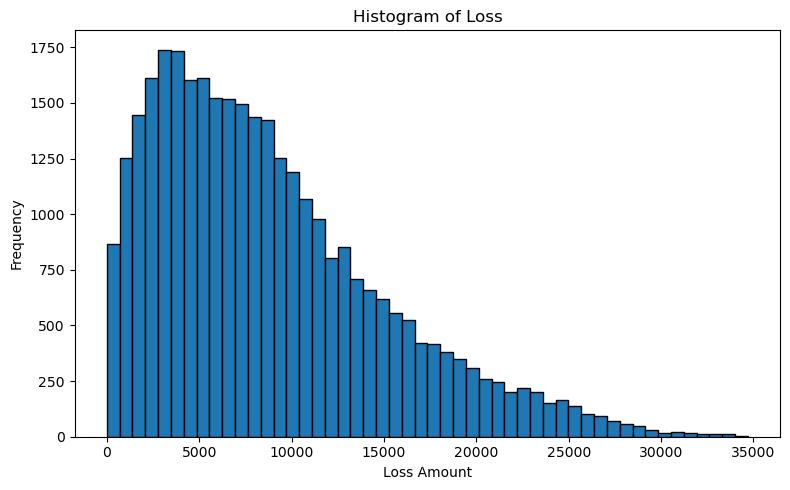

In [112]:
plt.figure(figsize=(8, 5))
plt.hist(defaulted_train['loss'], bins=50, edgecolor='k')
plt.title("Histogram of Loss")
plt.xlabel("Loss Amount")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Scatter plot between Loss and Other Numerical Features

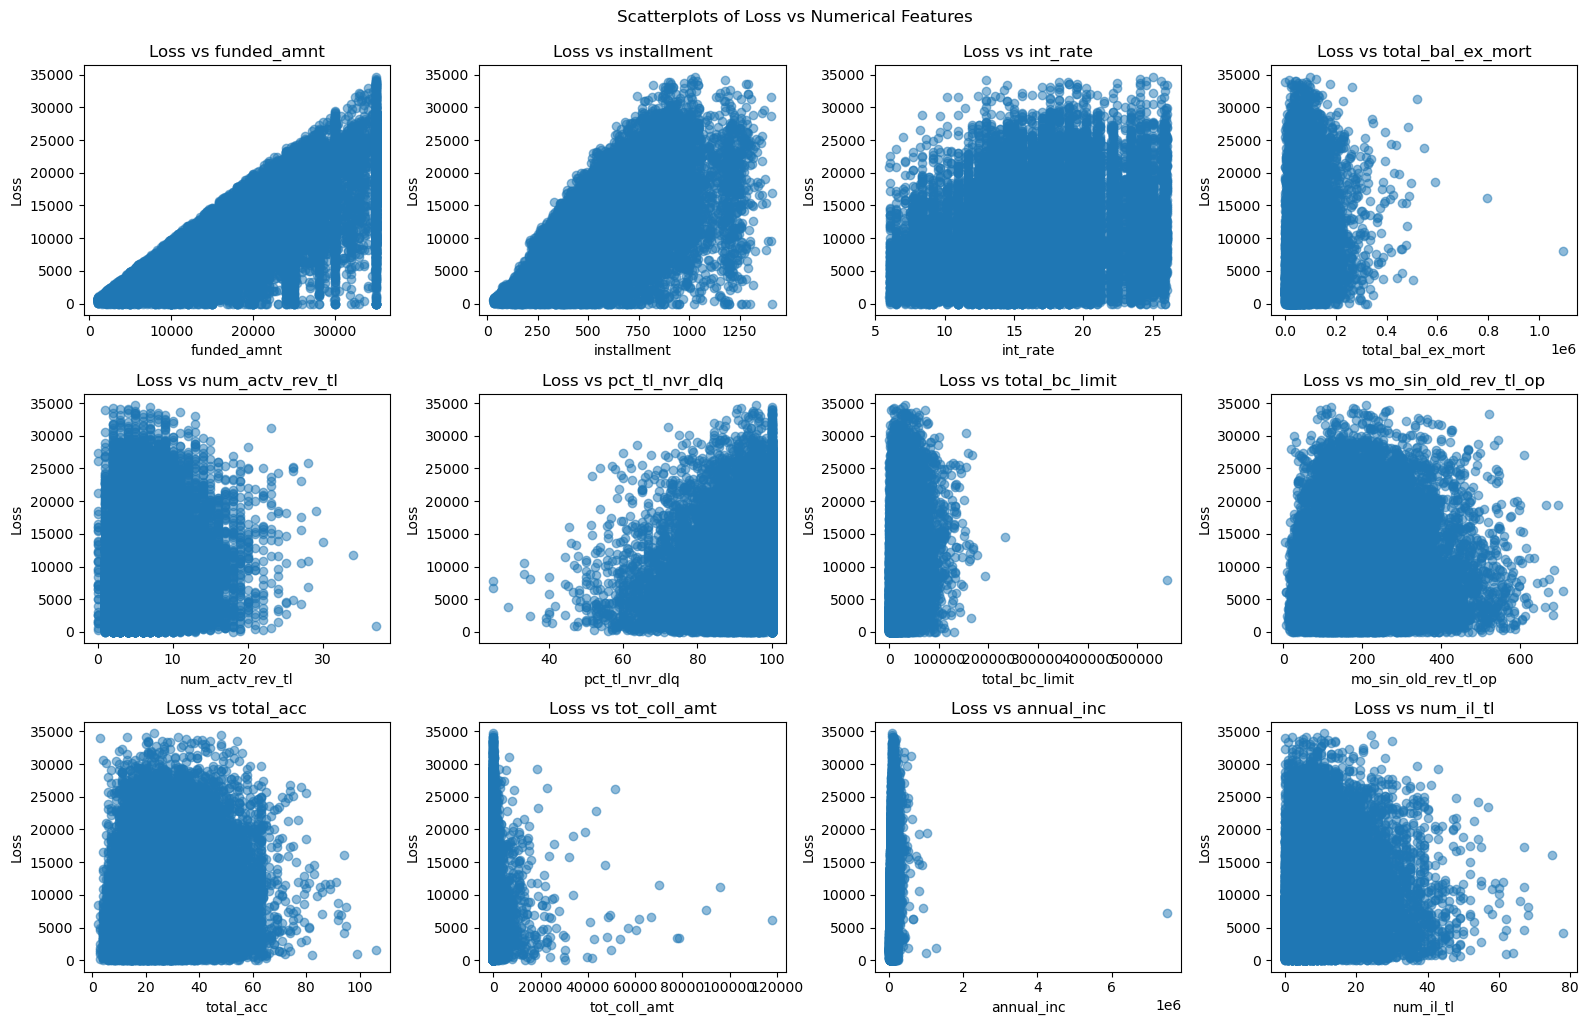

In [113]:
num_cols = defaulted_train.select_dtypes(include='number').columns

# Number of plots (limit if too many)
selected_cols = num_cols  # or num_cols[:12], for example

# Grid size (e.g., 3 rows × 4 columns)
n_rows, n_cols = 3, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 10))
axes = axes.flatten()

# Plot scatterplots
for i, col in enumerate(selected_cols[:n_rows * n_cols]):
    axes[i].scatter(defaulted_train[col], defaulted_train['loss'], alpha=0.5)
    axes[i].set_title(f'Loss vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Loss')

# Hide unused axes if any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Scatterplots of Loss vs Numerical Features", y=1.02)
plt.show()


### Scatter plot between Loss and Log of Other Numerical Features

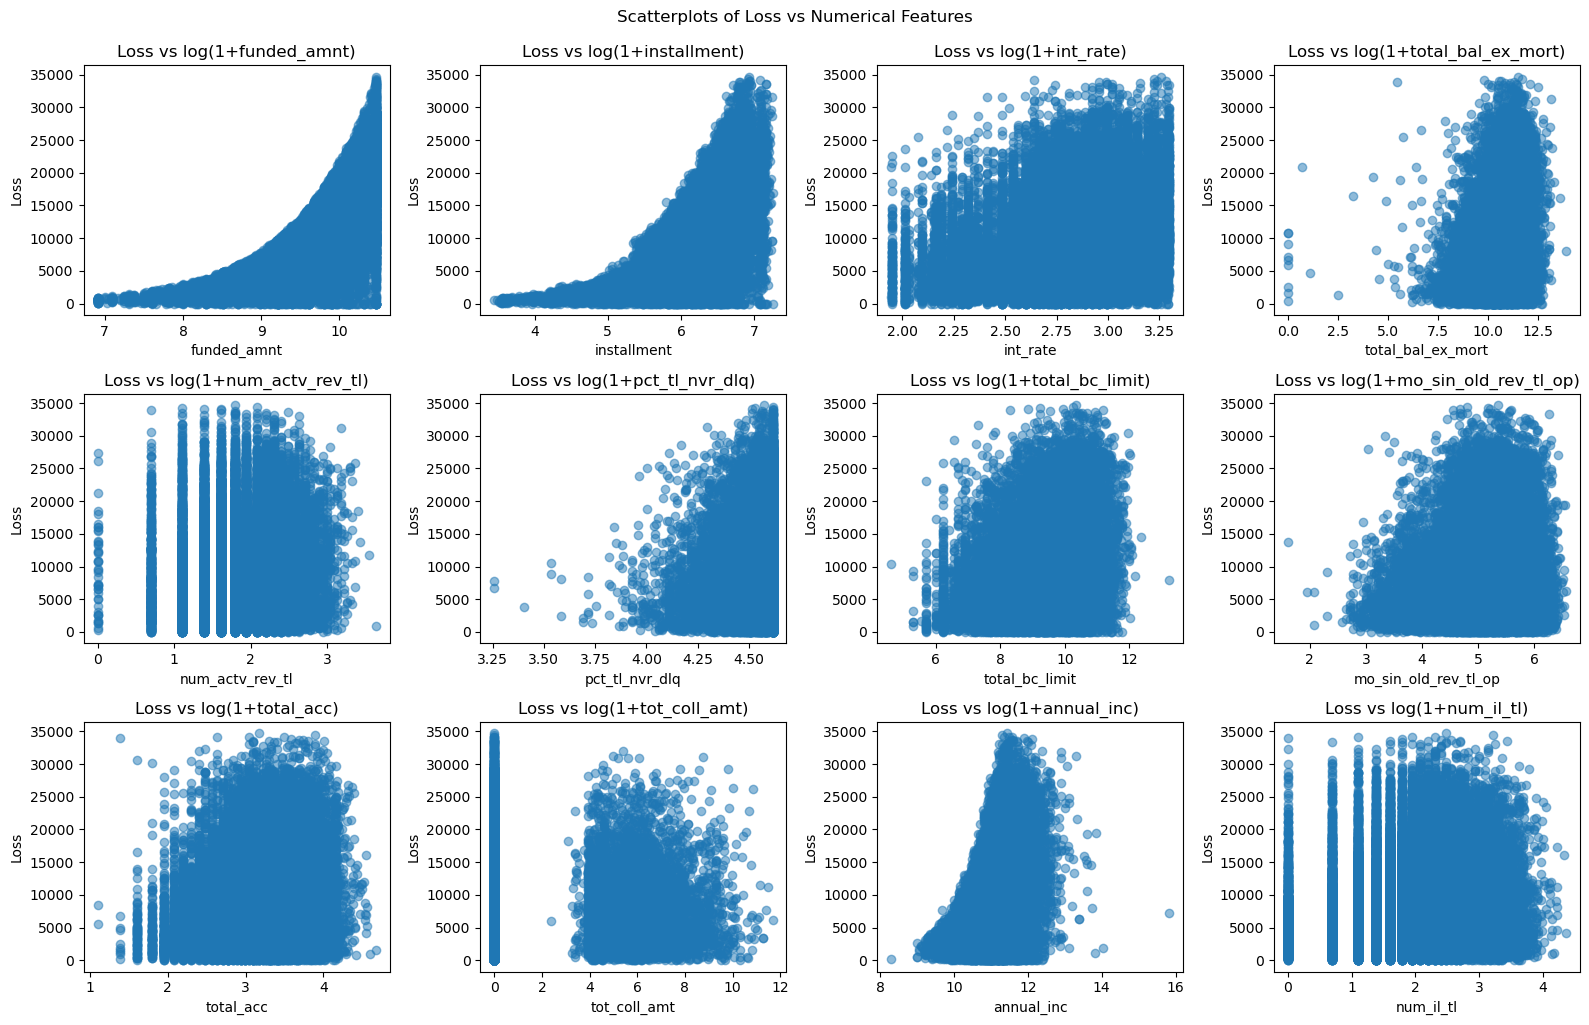

In [115]:
num_cols = defaulted_train.select_dtypes(include='number').columns

# Number of plots (limit if too many)
selected_cols = num_cols  # or num_cols[:12], for example

# Grid size (e.g., 3 rows × 4 columns)
n_rows, n_cols = 3, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 10))
axes = axes.flatten()

# Plot scatterplots
for i, col in enumerate(selected_cols[:n_rows * n_cols]):
    axes[i].scatter(np.log1p(defaulted_train[col]), defaulted_train['loss'], alpha=0.5)
    axes[i].set_title(f'Loss vs log(1+{col})')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Loss')

# Hide unused axes if any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Scatterplots of Loss vs Numerical Features", y=1.02)
plt.show()


### Correlation Plot Matrix Between Numerical Variables

Based on this graph, the amount of loss is highly correlated with ``funded_amnt`` and ``installement``. So, we expect that these two variables are strong predictors of loss

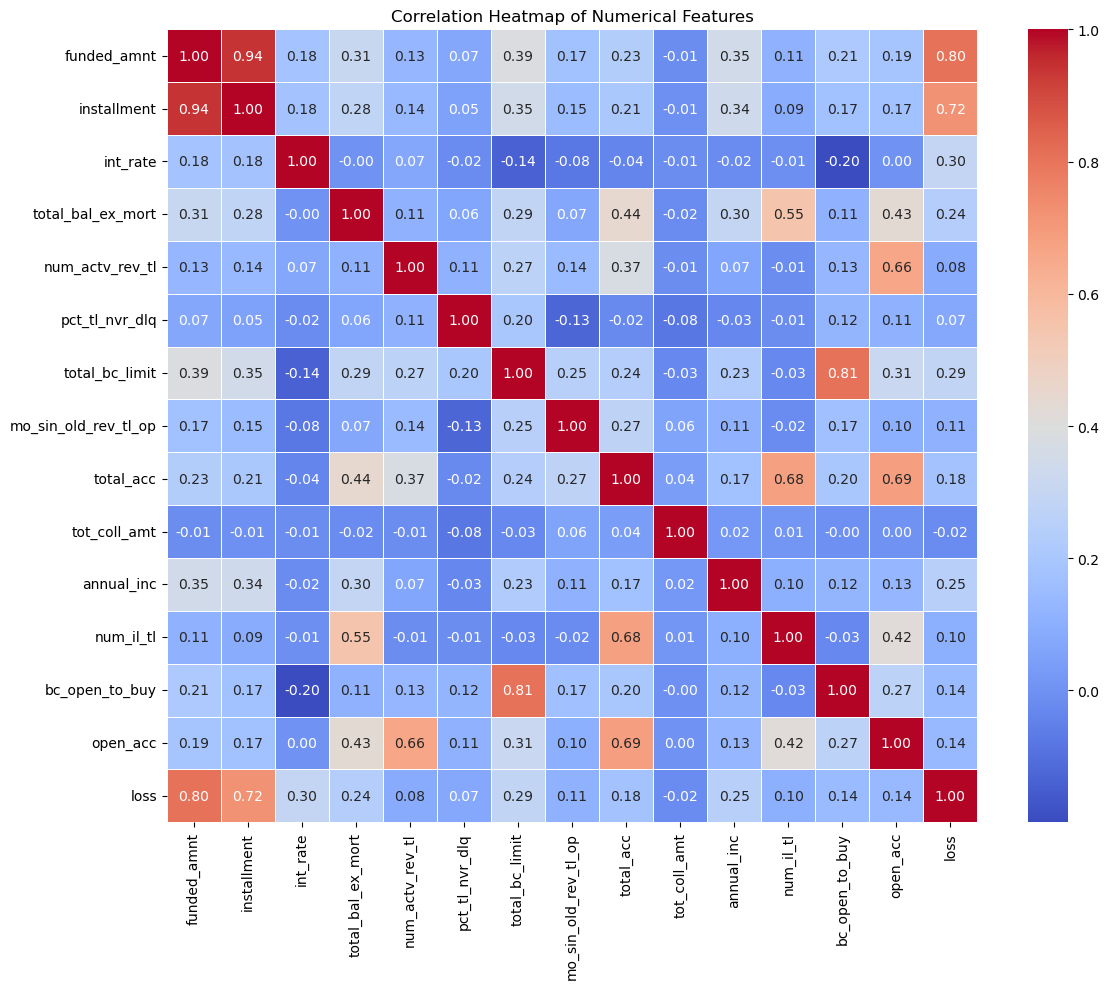

In [117]:


# Compute correlation matrix
corr_matrix = defaulted_train[num_cols].corr()

# Plot heatmap with annotations
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

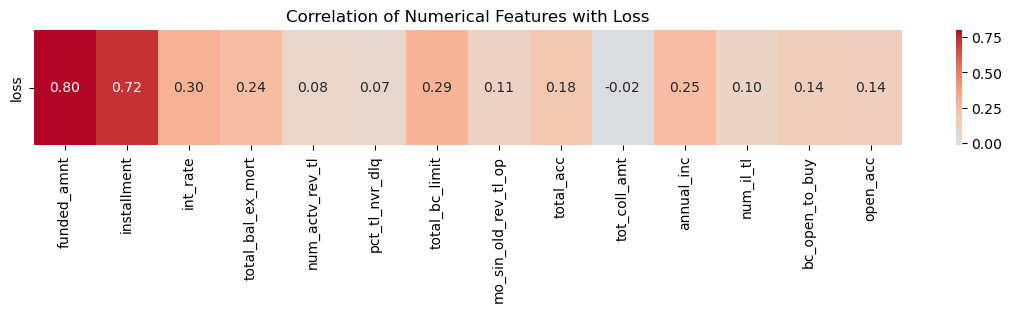

In [118]:
# Compute correlations with 'loss' only
corr_with_loss = defaulted_train[num_cols].corr()['loss'].drop('loss')  # drop self-correlation

# Convert to DataFrame for heatmap
corr_df = corr_with_loss.to_frame().T  # makes it a row for heatmap

# Plot heatmap
plt.figure(figsize=(14, 1.5))
sns.heatmap(corr_df, cmap='coolwarm', annot=True, fmt=".2f", center=0)
plt.title("Correlation of Numerical Features with Loss")
plt.tight_layout()
plt.show()

# Loss Prediction

In [130]:
def rmse_score(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)


# X and y
X_raw = defaulted_train.drop(columns=['loss'])
y = defaulted_train['loss']

# Log-transform numerical columns
num_cols = X_raw.select_dtypes(include='number').columns
X_raw[num_cols] = np.log1p(X_raw[num_cols])

# Convert object columns to category (especially for LightGBM)
for col in X_raw.select_dtypes(include='object').columns:
    X_raw[col] = X_raw[col].astype('category')

# Scoring metrics for regression
scoring = {
    'rmse': make_scorer(rmse_score, greater_is_better=False),
    'mae': make_scorer(mean_absolute_error),
    'r2': make_scorer(r2_score)
}

# Cross-validation setup (not stratified)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Regression models
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "Linear Regression": LinearRegression()
}

# Evaluation loop
results = {}
for name, model in models.items():
    print(f"Running {name}...")

    # Use raw categorical features for LightGBM
    if name == 'LightGBM':
        X_model = X_raw.copy()
    else:
        # One-hot encoding for categorical features
        X_model = pd.get_dummies(X_raw, drop_first=True)

    # Evaluate
    scores = cross_validate(model, X_model, y, cv=cv, scoring=scoring)
    results[name] = {metric: scores[f'test_{metric}'].mean() for metric in scoring}

# Show results
results_df = pd.DataFrame(results).T
print(results_df)


Running Random Forest...
Running LightGBM...
Running Gradient Boosting...
Running XGBoost...
Running Linear Regression...
                          rmse          mae        r2
Random Forest     -3564.339830  2586.129070  0.672283
LightGBM          -3512.766727  2541.930787  0.681690
Gradient Boosting -3486.286378  2536.230344  0.686488
XGBoost           -3627.092356  2611.422939  0.660671
Linear Regression -3880.575624  2911.406447  0.611563


In [132]:
import statsmodels.api as sm
from statsmodels.genmod.families import Gamma
from statsmodels.genmod.families.links import log as log_link  # log link for Gamma

# Step 1: Prepare X and y
X = defaulted_train.drop(columns=['loss'])
y = defaulted_train['loss']

# Step 2: Ensure y is strictly positive
epsilon = 1e-5
y = y.clip(lower=epsilon)

# Step 3: Log-transform numeric columns
num_cols = X.select_dtypes(include='number').columns
X[num_cols] = np.log1p(X[num_cols])

# Step 4: Encode categorical variables
X = func_target_encoding(X, y)

# Step 5: Add constant for intercept
X = sm.add_constant(X)

# Step 6: Fit Gamma Regression using GLM
model = sm.GLM(y, X, family=Gamma(link=log_link()))
result = model.fit()

# Step 7: Summary
print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   loss   No. Observations:                32407
Model:                            GLM   Df Residuals:                    32389
Model Family:                   Gamma   Df Model:                           17
Link Function:                    log   Scale:                         0.15279
Method:                          IRLS   Log-Likelihood:            -3.2373e+05
Date:                Wed, 07 May 2025   Deviance:                       13008.
Time:                        18:13:16   Pearson chi2:                 4.95e+03
No. Iterations:                    30   Pseudo R-squ. (CS):             0.9262
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.3690 

### Removing insignificant variables

Since p-values of some variables are large, we remove those variables. Based on the following results. We can observe that there is no change in the performance of the algorithm.

Based on the results, ``Gamma regression`` is better than other machine learning approaches.

In [134]:
features_to_drop = ['installment', 'total_bal_ex_mort', 'num_il_tl', 'bc_open_to_buy', 'open_acc']

In [136]:
# Step 1: Prepare X and y
X = defaulted_train.drop(columns=features_to_drop+['loss'])
y = defaulted_train['loss']

# Step 2: Ensure y is strictly positive
epsilon = 1e-5
y = y.clip(lower=epsilon)

# Step 3: Log-transform numeric columns
num_cols = X.select_dtypes(include='number').columns
X[num_cols] = np.log1p(X[num_cols])

# Step 4: Encode categorical variables
X = func_target_encoding(X, y)

# Step 5: Add constant for intercept
X = sm.add_constant(X)

# Step 6: Fit Gamma Regression using GLM
model = sm.GLM(y, X, family=Gamma(link=log_link()))
result = model.fit()

# Step 7: Summary
print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   loss   No. Observations:                32407
Model:                            GLM   Df Residuals:                    32394
Model Family:                   Gamma   Df Model:                           12
Link Function:                    log   Scale:                         0.15274
Method:                          IRLS   Log-Likelihood:            -3.2374e+05
Date:                Wed, 07 May 2025   Deviance:                       13009.
Time:                        18:19:51   Pearson chi2:                 4.95e+03
No. Iterations:                    52   Pseudo R-squ. (CS):             0.9262
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.9148 

In [139]:
y_true = result.model.endog             # Actual target values (loss)
y_pred = result.predict()               # Predicted values from the GLM model

# Compute metrics
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

RMSE: 3479.02
MAE: 2521.64
R²: 0.6879


### Plot actual vs. predicted values

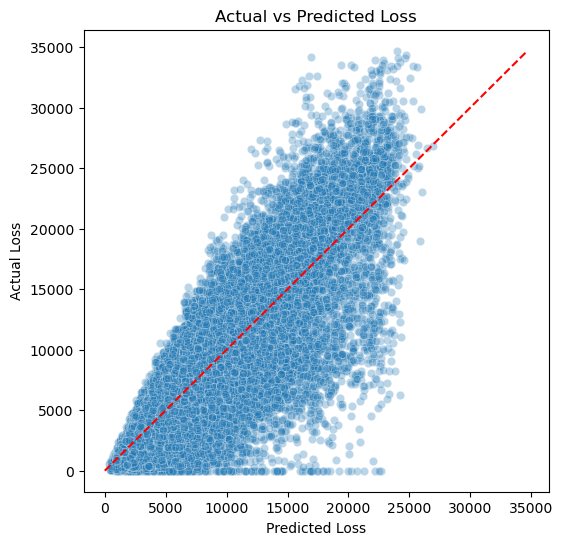

In [140]:
# Residuals
residuals = y_true - y_pred

# Actual vs Predicted
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_pred, y=y_true, alpha=0.3)
plt.xlabel("Predicted Loss")
plt.ylabel("Actual Loss")
plt.title("Actual vs Predicted Loss")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r')
plt.show()

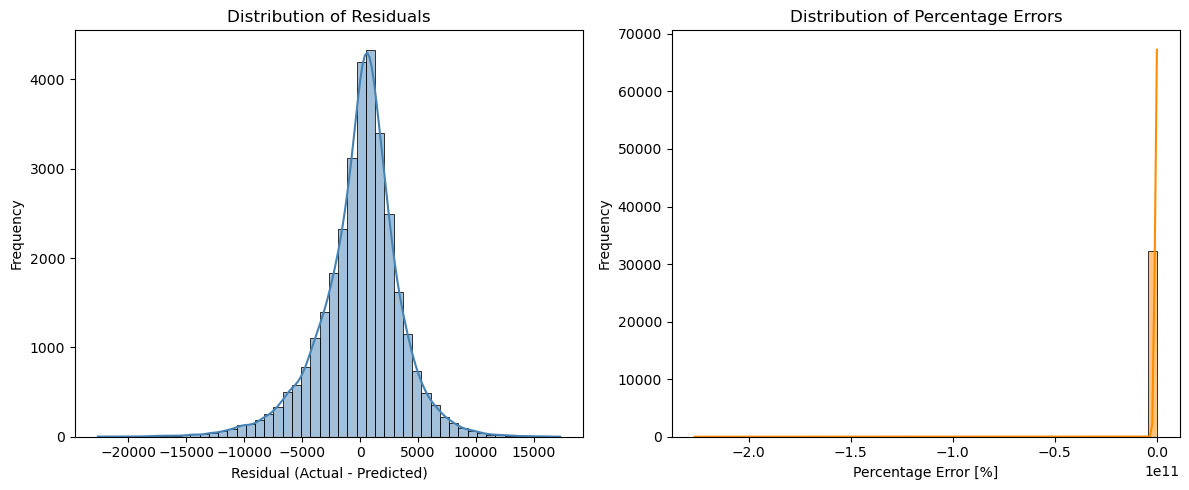

In [142]:
residuals = y_true - y_pred
percent_errors = 100 * residuals / y_true

# Plot residuals
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(residuals, bins=50, kde=True, color='steelblue')
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")

# Plot percentage errors
plt.subplot(1, 2, 2)
sns.histplot(percent_errors, bins=50, kde=True, color='darkorange')
plt.title("Distribution of Percentage Errors")
plt.xlabel("Percentage Error [%]")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()